# Bank Marketing Data Set

Attribute Information (bank client data):

- age (numeric)
- job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
- marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
- education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
- default: has credit in default? (categorical: "no","yes","unknown")
- housing: has housing loan? (categorical: "no","yes","unknown")
- loan: has personal loan? (categorical: "no","yes","unknown")

Related with the last contact of the current campaign:
- contact: contact communication type (categorical: "cellular","telephone") 
- month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
- day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
- duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
- social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)     
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y: has the client subscribed a term deposit? (binary: "yes","no")

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import missingno as msno

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Temporarily set to ignore FutureWarnings due to the potential use of different versions of utilized libraries.

In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Data Inspection

In [4]:
df = pd.read_csv("data/bank-additional-full.csv", sep=";")

In [5]:
df.head(10).T

0            1            2            3  \
age                      56           57           37           40   
job               housemaid     services     services       admin.   
marital             married      married      married      married   
education          basic.4y  high.school  high.school     basic.6y   
default                  no      unknown           no           no   
housing                  no           no          yes           no   
loan                     no           no           no           no   
contact           telephone    telephone    telephone    telephone   
month                   may          may          may          may   
day_of_week             mon          mon          mon          mon   
duration                261          149          226          151   
campaign                  1            1            1            1   
pdays                   999          999          999          999   
previous                  0            0            0            0   
poutcome        nonexistent  nonexistent  nonexistent  nonexistent   
emp.var.rate            1.1          1.1          1.1          1.1   
cons.price.idx       93.994       93.994       93.994       93.994   
cons.conf.idx         -36.4        -36.4        -36.4        -36.4   
euribor3m             4.857        4.857        4.857        4.857   
nr.employed          5191.0       5191.0       5191.0       5191.0   
y                        no           no           no           no   

                          4            5                    6            7  \
age                      56           45                   59           41   
job                services     services               admin.  blue-collar   
marital             married      married              married      married   
education       high.school     basic.9y  professional.course      unknown   
default                  no      unknown                   no      unknown   
housing                  no           no                   no           no   
loan                    yes           no                   no           no   
contact           telephone    telephone            telephone    telephone   
month                   may          may                  may          may   
day_of_week             mon          mon                  mon          mon   
duration                307          198                  139          217   
campaign                  1            1                    1            1   
pdays                   999          999                  999          999   
previous                  0            0                    0            0   
poutcome        nonexistent  nonexistent          nonexistent  nonexistent   
emp.var.rate            1.1          1.1                  1.1          1.1   
cons.price.idx       93.994       93.994               93.994       93.994   
cons.conf.idx         -36.4        -36.4                -36.4        -36.4   
euribor3m             4.857        4.857                4.857        4.857   
nr.employed          5191.0       5191.0               5191.0       5191.0   
y                        no           no                   no           no   

                                  8            9  
age                              24           25  
job                      technician     services  
marital                      single       single  
education       professional.course  high.school  
default                          no           no  
housing                         yes          yes  
loan                             no           no  
contact                   telephone    telephone  
month                           may          may  
day_of_week                     mon          mon  
duration                        380           50  
campaign                          1            1  
pdays                           999          999  
previous                          0            0  
pou

For improved readability, dots (".") in column names and certain cell values have been replaced with underscores ("_").

In [6]:
df.columns = df.columns.str.replace(".", "_")
df[df.select_dtypes(include="object").columns] = df.select_dtypes(include="object").apply(lambda x: x.str.replace(".", "_"))

In [7]:
df.shape

(41188, 21)

Let's check whether there are missing values in the attributes and what is their type. Of course, it's worth noting that missing values in the categorical attributes are marked as 'unknown'.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

Fortunately, there are no missing data in the target feature.

In [9]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

- helper function for counting the number of missing data in a particular attribute:

In [10]:
count_nan_vals = lambda data: data.isna().sum()

In [11]:
count_nan_vals(df)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

There are no missing values in the numerical features.

In [12]:
df.min()

age                     17
job                 admin_
marital           divorced
education         basic_4y
default                 no
housing                 no
loan                    no
contact           cellular
month                  apr
day_of_week            fri
duration                 0
campaign                 1
pdays                    0
previous                 0
poutcome           failure
emp_var_rate          -3.4
cons_price_idx      92.201
cons_conf_idx        -50.8
euribor3m            0.634
nr_employed         4963.6
y                       no
dtype: object

In [13]:
df.max()

age                      98
job                 unknown
marital             unknown
education           unknown
default                 yes
housing                 yes
loan                    yes
contact           telephone
month                   sep
day_of_week             wed
duration               4918
campaign                 56
pdays                   999
previous                  7
poutcome            success
emp_var_rate            1.4
cons_price_idx       94.767
cons_conf_idx         -26.9
euribor3m             5.045
nr_employed          5228.1
y                       yes
dtype: object

Using min/max aggregate functions can help with finding odd values in the dataset, values that deviate from actual data, etc.

There is the number '999' that indicates a limit for specific data values. Let's check it:

In [14]:
df["pdays"].value_counts()

pdays
999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

Creating a new categorical feature called "previous_contact" based on the "pdays" attribute.
The new feature indicates whether there was previous contact with the client.
If the value in "pdays" is equal to 999, it suggests no previous contact ("no"), otherwise, it indicates previous contact ("yes").

It can be done this way because the value '999' is predominant, and the impact of the remaining values of the attribute is minimal on the quality of the future model.

In [15]:
df["previous_contact"] = df["pdays"].apply(lambda x: "no" if x == 999 else "yes")
df.drop(columns=["pdays"], inplace=True)

### Missing Values

Let's temporarily replace the 'unknown' values in the categorical features with NaN to utilize the built-in visualization tool.

In [16]:
df_with_nan = df.replace("unknown", np.NaN)

In [17]:
total_nan = count_nan_vals(df_with_nan)
total_nan

age                    0
job                  330
marital               80
education           1731
default             8597
housing              990
loan                 990
contact                0
month                  0
day_of_week            0
duration               0
campaign               0
previous               0
poutcome               0
emp_var_rate           0
cons_price_idx         0
cons_conf_idx          0
euribor3m              0
nr_employed            0
y                      0
previous_contact       0
dtype: int64

<Axes: >

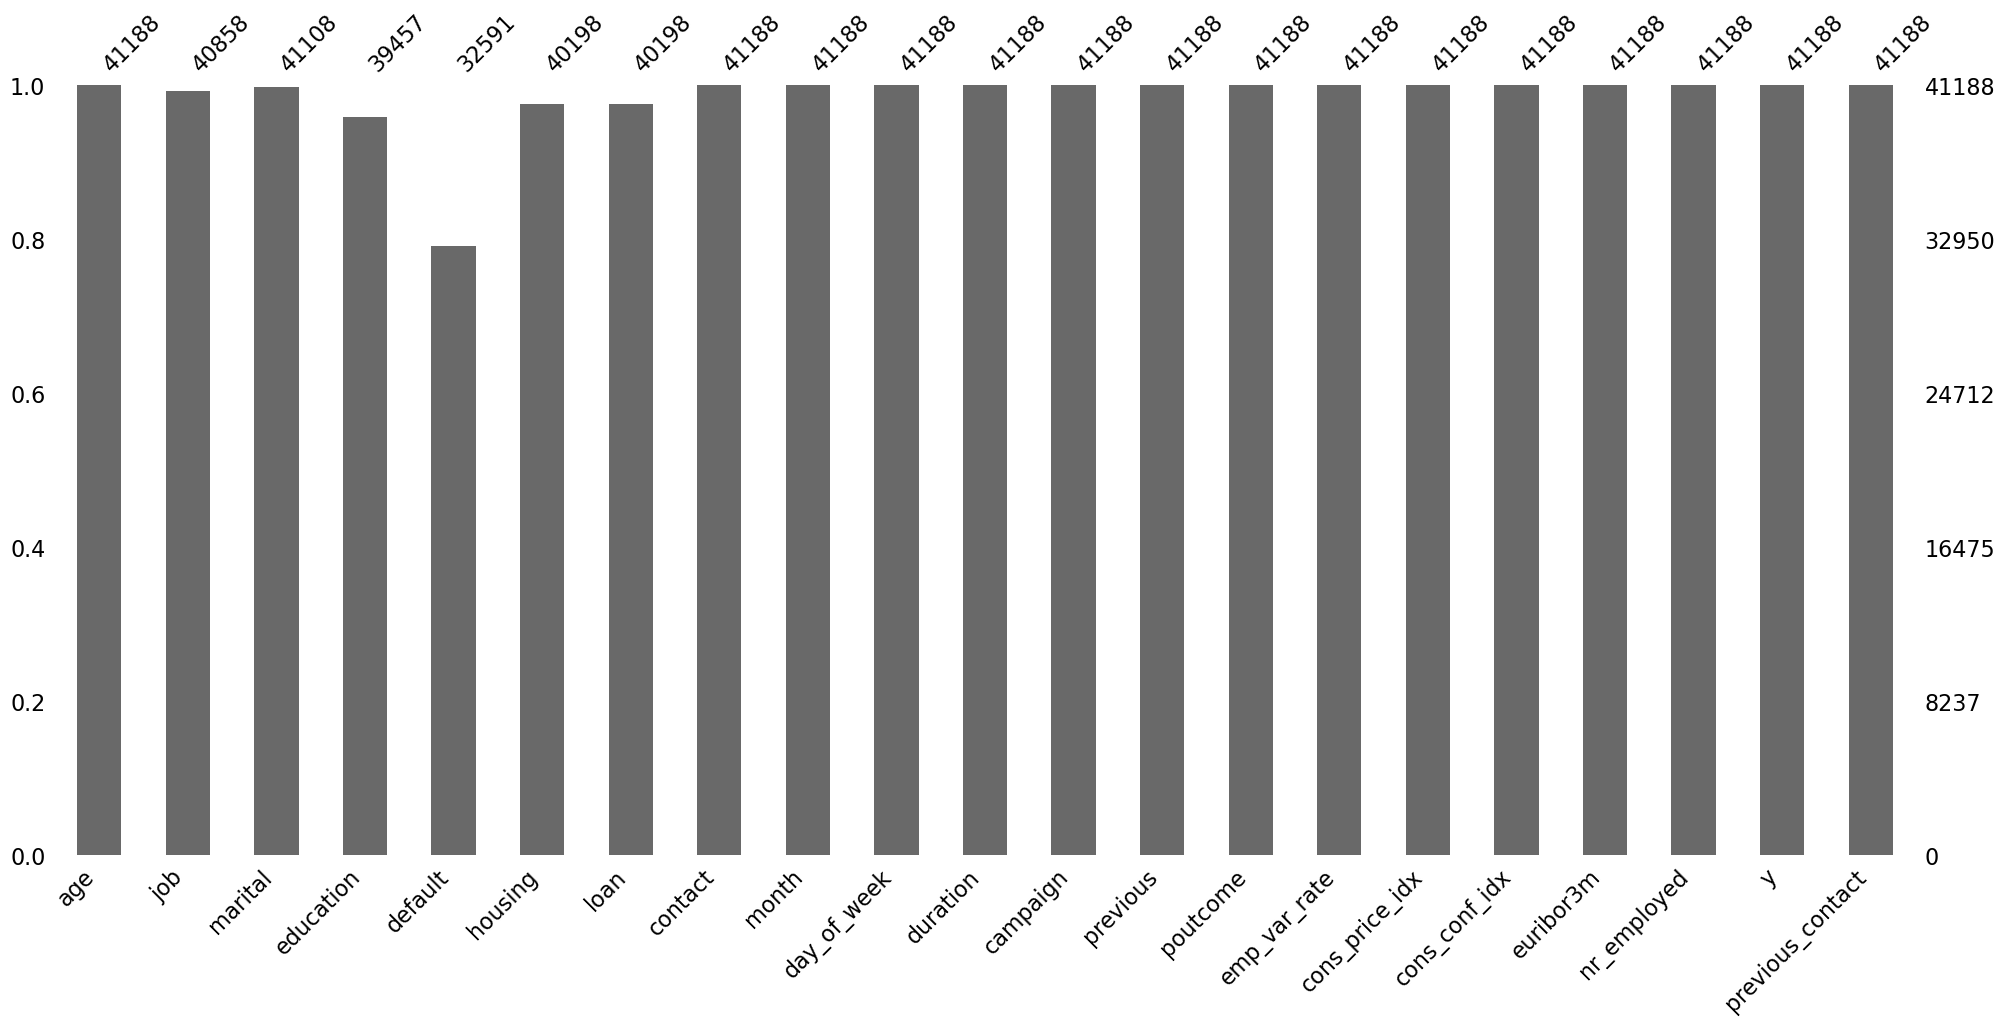

In [18]:
msno.bar(df_with_nan)

Examine the percentage of missing values for the specified attributes:

In [19]:
round((total_nan/df.shape[0])*100, 3).sort_values(ascending=False)

default             20.873
education            4.203
housing              2.404
loan                 2.404
job                  0.801
marital              0.194
age                  0.000
emp_var_rate         0.000
y                    0.000
nr_employed          0.000
euribor3m            0.000
cons_conf_idx        0.000
cons_price_idx       0.000
duration             0.000
poutcome             0.000
previous             0.000
campaign             0.000
day_of_week          0.000
month                0.000
contact              0.000
previous_contact     0.000
dtype: float64

A significant portion of data is missing in the 'default' feature. Consequently, imputation may be necessary to handle this attribute during analysis. Additionally, five other attributes have a small percentage of missing data. For certain machine learning models, deleting rows containing missing values in these five attributes could be a viable approach.

However, sometimes it is a good idea to leave missing values in categorical features as an 'unknown' category because it can be useful for the model.

In the Data Preparation section rows containing missing values in education, housing, loan, job and marital features will be removed.

In [20]:
df.dtypes

age                   int64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
previous              int64
poutcome             object
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                    object
previous_contact     object
dtype: object

### Handle Duplicates

Before proceeding with the analysis, it is essential to delete duplicate rows.

In [21]:
df.duplicated().sum()

12

In [22]:
df[df.duplicated()].T

1266         12261                14234        16956  \
age                        39           36                   27           47   
job               blue-collar      retired           technician   technician   
marital               married      married               single     divorced   
education            basic_6y      unknown  professional_course  high_school   
default                    no           no                   no           no   
housing                    no           no                   no          yes   
loan                       no           no                   no           no   
contact             telephone    telephone             cellular     cellular   
month                     may          jul                  jul          jul   
day_of_week               thu          thu                  mon          thu   
duration                  124           88                  331           43   
campaign                    1            1                    2            3   
previous                    0            0                    0            0   
poutcome          nonexistent  nonexistent          nonexistent  nonexistent   
emp_var_rate              1.1          1.4                  1.4          1.4   
cons_price_idx         93.994       93.918               93.918       93.918   
cons_conf_idx           -36.4        -42.7                -42.7        -42.7   
euribor3m               4.855        4.966                4.962        4.962   
nr_employed            5191.0       5228.1               5228.1       5228.1   
y                          no           no                   no           no   
previous_contact           no           no                   no           no   

                                18465        20216                20534  \
age                                32           55                   41   
job                        technician     services           technician   
marital                        single      married              married   
education         professional_course  high_school  professional_course   
default                            no      unknown                   no   
housing                           yes           no                  yes   
loan                               no           no                   no   
contact                      cellular     cellular             cellular   
month                             jul          aug                  aug   
day_of_week                       thu          mon                  tue   
duration                          128           33                  127   
campaign                            1            1                    1   
previous                            0            0                    0   
poutcome                  nonexistent  nonexistent          nonexistent   
emp_var_rate                      1.4          1.4                  1.4   
cons_price_idx                 93.918       93.444               93.444   
cons_conf_idx                   -42.7        -36.1                -36.1   
euribor3m                       4.968        4.965                4.966   
nr_employed                    5228.1       5228.1               5228.1   
y                                  no           no                   no   
previous_contact                   no           no                   no   

                              25217        28477              32516  \
age                              39           24                 35   
job                          admin_     services             admin_   
marital                     married       single            married   
education         university_degree  high_school  university_degree   
default                          no           no                 no   
housing                          no          yes                yes   
loan                             no           no                 no   
contact                    cellular     cell

In [23]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Verify whether the index has been reset correctly.

In [24]:
df.tail().T

41171                41172              41173  \
age                                73                   46                 56   
job                           retired          blue-collar            retired   
marital                       married              married            married   
education         professional_course  professional_course  university_degree   
default                            no                   no                 no   
housing                           yes                   no                yes   
loan                               no                   no                 no   
contact                      cellular             cellular           cellular   
month                             nov                  nov                nov   
day_of_week                       fri                  fri                fri   
duration                          334                  383                189   
campaign                            1                    1                  2   
previous                            0                    0                  0   
poutcome                  nonexistent          nonexistent        nonexistent   
emp_var_rate                     -1.1                 -1.1               -1.1   
cons_price_idx                 94.767               94.767             94.767   
cons_conf_idx                   -50.8                -50.8              -50.8   
euribor3m                       1.028                1.028              1.028   
nr_employed                    4963.6               4963.6             4963.6   
y                                 yes                   no                 no   
previous_contact                   no                   no                 no   

                                41174                41175  
age                                44                   74  
job                        technician              retired  
marital                       married              married  
education         professional_course  professional_course  
default                            no                   no  
housing                            no                  yes  
loan                               no                   no  
contact                      cellular             cellular  
month                             nov                  nov  
day_of_week                       fri                  fri  
duration                          442                  239  
campaign                            1                    3  
previous                            0                    1  
poutcome                  nonexistent              failure  
emp_var_rate                     -1.1                 -1.1  
cons_price_idx                 94.767               94.767  
cons_conf_idx                   -50.8                -50.8  
euribor3m                       1.028                1.028  
nr_employed                    4963.6               4963.6  
y                                 yes                   no  
previous_contact                   no                   no

### Feature Division

In [25]:
categorical_features = pd.Series(["job", "marital", "education", "default", "housing", "loan", 
                                  "contact", "month", "day_of_week", "poutcome", "previous_contact"])
numerical_features = pd.Series(df.columns.difference(categorical_features))
target_feature = "y"
numerical_features = numerical_features[~(numerical_features == target_feature)]

In [26]:
categorical_features

0                  job
1              marital
2            education
3              default
4              housing
5                 loan
6              contact
7                month
8          day_of_week
9             poutcome
10    previous_contact
dtype: object

In [27]:
numerical_features

0               age
1          campaign
2     cons_conf_idx
3    cons_price_idx
4          duration
5      emp_var_rate
6         euribor3m
7       nr_employed
8          previous
dtype: object

---

# Descriptive Statistics

Examining the number of unique values in the categorical features:

In [28]:
df[categorical_features].nunique()

job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
poutcome             3
previous_contact     2
dtype: int64

In [29]:
for feature in categorical_features:
    print(f"----------{feature.upper()}----------")
    print(df[feature].value_counts(), end="\n\n")

----------JOB----------
job
admin_           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

----------MARITAL----------
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64

----------EDUCATION----------
education
university_degree      12164
high_school             9512
basic_9y                6045
professional_course     5240
basic_4y                4176
basic_6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64

----------DEFAULT----------
default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64

----------HOUSING----------
housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64

-------

Examining the number of unique values in the numerical features:

In [30]:
df[numerical_features].nunique()

age                 78
campaign            42
cons_conf_idx       26
cons_price_idx      26
duration          1544
emp_var_rate        10
euribor3m          316
nr_employed         11
previous             8
dtype: int64

Target feature values:

In [31]:
df[target_feature].value_counts()

y
no     36537
yes     4639
Name: count, dtype: int64

Lets's examine the statistics for all numerical features, and extend the analysis to include the Interquartile Range (IQR) parameter, along with lower and upper limits (Q1-1.5IQR and Q3+1.5IQR).

In [32]:
extended_describe = df.describe().T
extended_describe["IQR"] = extended_describe["75%"] - extended_describe["25%"]
extended_describe["lower_limit"] = extended_describe["25%"] - 1.5*extended_describe["IQR"]
extended_describe["upper_limit"] = extended_describe["75%"] + 1.5*extended_describe["IQR"]
extended_describe

count         mean         std       min       25%  \
age             41176.0    40.023800   10.420680    17.000    32.000   
duration        41176.0   258.315815  259.305321     0.000   102.000   
campaign        41176.0     2.567879    2.770318     1.000     1.000   
previous        41176.0     0.173013    0.494964     0.000     0.000   
emp_var_rate    41176.0     0.081922    1.570883    -3.400    -1.800   
cons_price_idx  41176.0    93.575720    0.578839    92.201    93.075   
cons_conf_idx   41176.0   -40.502863    4.627860   -50.800   -42.700   
euribor3m       41176.0     3.621293    1.734437     0.634     1.344   
nr_employed     41176.0  5167.034870   72.251364  4963.600  5099.100   

                     50%       75%       max      IQR  lower_limit  \
age               38.000    47.000    98.000   15.000       9.5000   
duration         180.000   319.000  4918.000  217.000    -223.5000   
campaign           2.000     3.000    56.000    2.000      -2.0000   
previous           0.000     0.000     7.000    0.000       0.0000   
emp_var_rate       1.100     1.400     1.400    3.200      -6.6000   
cons_price_idx    93.749    93.994    94.767    0.919      91.6965   
cons_conf_idx    -41.800   -36.400   -26.900    6.300     -52.1500   
euribor3m          4.857     4.961     5.045    3.617      -4.0815   
nr_employed     5191.000  5228.100  5228.100  129.000    4905.6000   

                upper_limit  
age                 69.5000  
duration           644.5000  
campaign             6.0000  
previous             0.0000  
emp_var_rate         6.2000  
cons_price_idx      95.3725  
cons_conf_idx      -26.9500  
euribor3m           10.3865  
nr_employed       5421.6000

We can clearly see that only two attributes  

In [33]:
df[target_feature]

0         no
1         no
2         no
3         no
4         no
        ... 
41171    yes
41172     no
41173     no
41174    yes
41175     no
Name: y, Length: 41176, dtype: object

In [34]:
target_feature_perc = pd.DataFrame(df[target_feature].value_counts(normalize=True)*100).rename(index={0: "no", 1: "yes"})
target_feature_perc

proportion
y              
no    88.733728
yes   11.266272

---

# Data Visualization

In [35]:
sns.set(style="whitegrid", palette="bright")

## Univariate Analysis

### Target Feature (Categorical)

Let's see and plot the percentage distribution of target feature values.

In [36]:
target_feature_perc

proportion
y              
no    88.733728
yes   11.266272

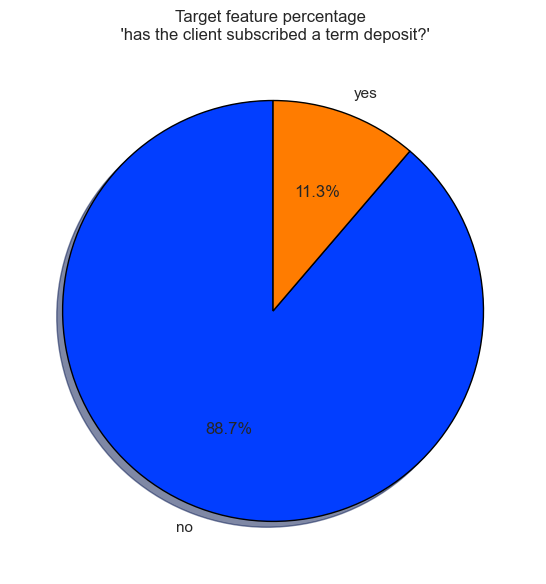

In [37]:
plt.figure(figsize=(8, 6))
plt.pie(target_feature_perc["proportion"].values, labels=target_feature_perc.index, 
        shadow=True, startangle=90, autopct="%1.1f%%", wedgeprops={"edgecolor": "black"})
plt.title("Target feature percentage \n 'has the client subscribed a term deposit?'")
plt.tight_layout()
plt.show()

We are dealing with an imbalanced dataset in which the majority of customers did not subscribe to a term deposit. Depending on the machine learning model used, we can employ a technique called dataset balancing. There are two methods:

- Undersampling: removing examples from the dominant class,
- Oversampling: generating additional examples from the minority class.

Undersampling works well when the imbalance is slight, and the dataset is large (allowing for the removal of some examples). Oversampling typically yields better results, and there are very effective algorithms for it.

A common oversampling algorithm is SMOTE (Synthetic Minority Oversampling TEchnique).

Of course, this is only Exploratory Data Analysis, so we won't be using these techniques in this notebook analysis.

### Numerical Features

Now, we can create subplots to visualize histograms with additional information for all the numerical features.

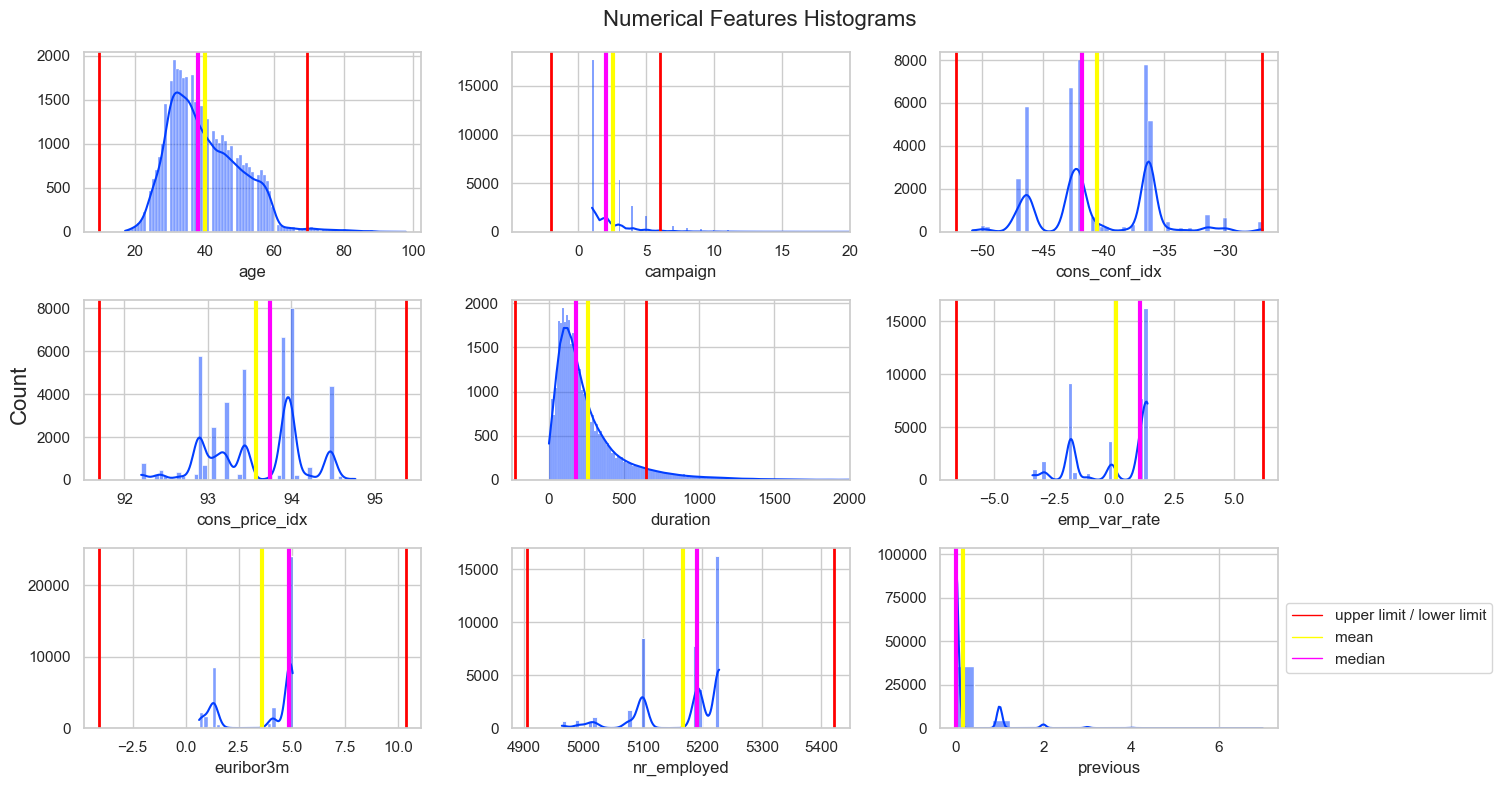

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    g = sns.histplot(data=df, x=feature, ax=axes[i], kde=True)

    axes[i].axvline(extended_describe.loc[feature, "upper_limit"], linewidth=2 , color="red")
    axes[i].axvline(extended_describe.loc[feature, "lower_limit"], linewidth=2 , color="red")
    axes[i].axvline(extended_describe.loc[feature, "mean"], linewidth=3 , color="yellow")
    axes[i].axvline(extended_describe.loc[feature, "50%"], linewidth=3 , color="magenta")
    if feature == "duration":
        axes[i].set_xlim(right=2000)
    elif feature == "campaign":
        axes[i].set_xlim(right=20)
        
    g.set(ylabel=None)
        
limits = mlines.Line2D([], [], color="red", linewidth=1, label="upper limit / lower limit")
mean = mlines.Line2D([], [], color="yellow", linewidth=1, label="mean")
median = mlines.Line2D([], [], color="magenta", linewidth=1, label="median")

plt.legend(handles=[limits, mean, median], loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle("Numerical Features Histograms", fontsize=16)
fig.text(0, 0.5, "Count", va="center", rotation="vertical", fontsize=16)

plt.tight_layout()
plt.show()

As we can see, only two attributes (age and duration) will have data value distributions that closely align with the 'reference' shapes observed in typical distributions found in literature. The distributions of the other attributes are ambiguous along the variable values.

Both age and duration distributions have positive skewness (mean > median > mode).

For almost all numerical features, the number of outliers is negligibly small. Only the duration feature has significantly more outliers, but this is due to positive kurtosis. Therefore, at this stage of the analysis, there won't be a 'Deal with outliers' step, considering the conclusions that have been drawn.

- helper functions for creating boxplot and violinplot visualizations for the 'age' and 'duration' features

In [39]:
def boxplot_age_duration(x=None, hue=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    axes = axes.flatten()
    sns.boxplot(data=df, x=x, hue=hue, y="age", ax=axes[0])
    sns.boxplot(data=df, x=x, hue=hue, y="duration", ax=axes[1])
    axes[0].tick_params(axis="x", rotation=90)
    axes[1].tick_params(axis="x", rotation=90)
    plt.suptitle("'Age' and 'Duration' features boxplots")
    plt.tight_layout()
    plt.show()

In [40]:
def violin_age_duration(x=None, hue=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    axes = axes.flatten()
    sns.violinplot(data=df, x=x, hue=hue, y="age", ax=axes[0], split=True, inner="quart")
    sns.violinplot(data=df, x=x, hue=hue, y="duration", ax=axes[1], split=True, inner="quart")
    axes[0].tick_params(axis="x", rotation=90)
    axes[1].tick_params(axis="x", rotation=90)
    plt.suptitle("'Age' and 'Duration' features violinplots")
    plt.tight_layout()
    plt.show()

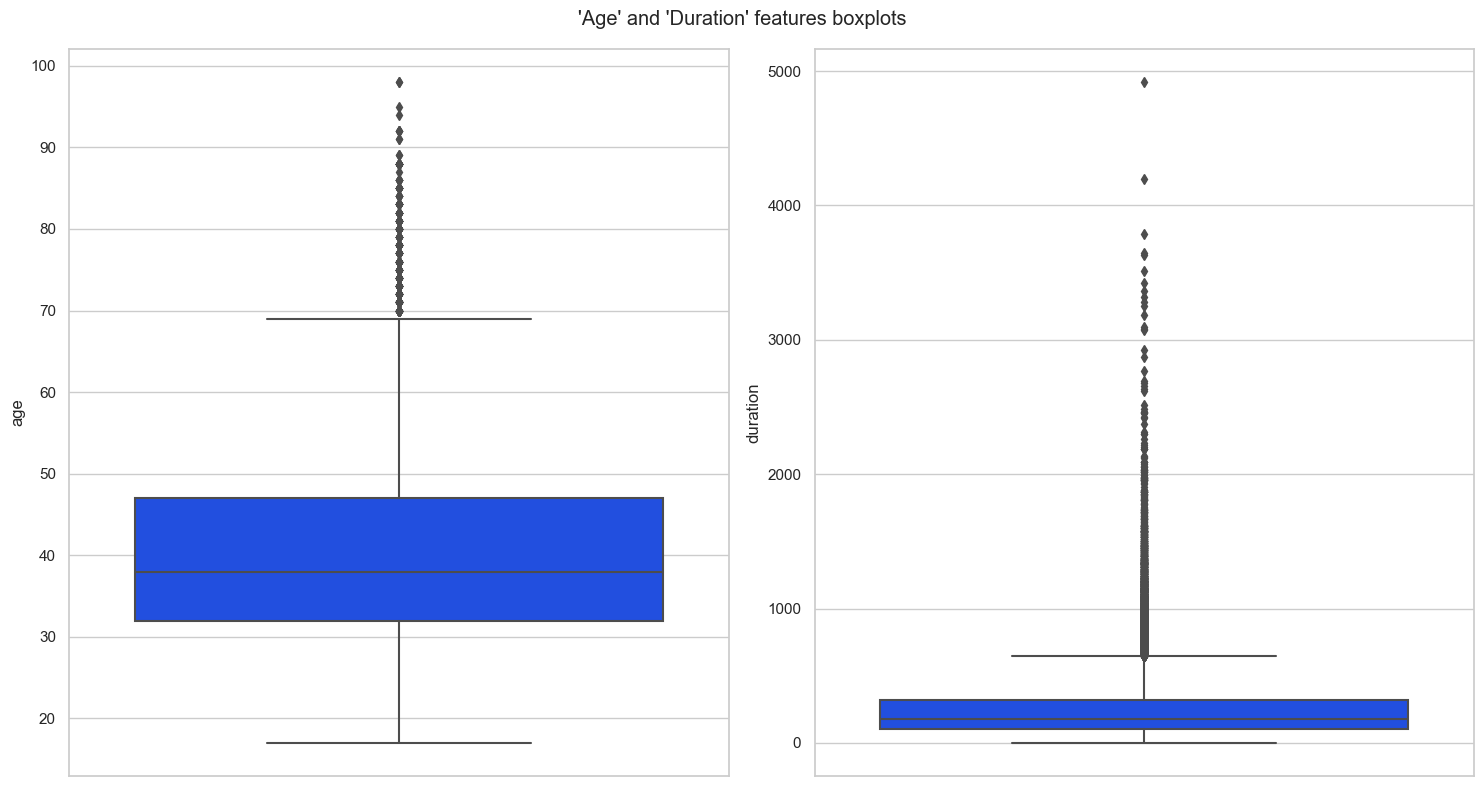

In [41]:
boxplot_age_duration()

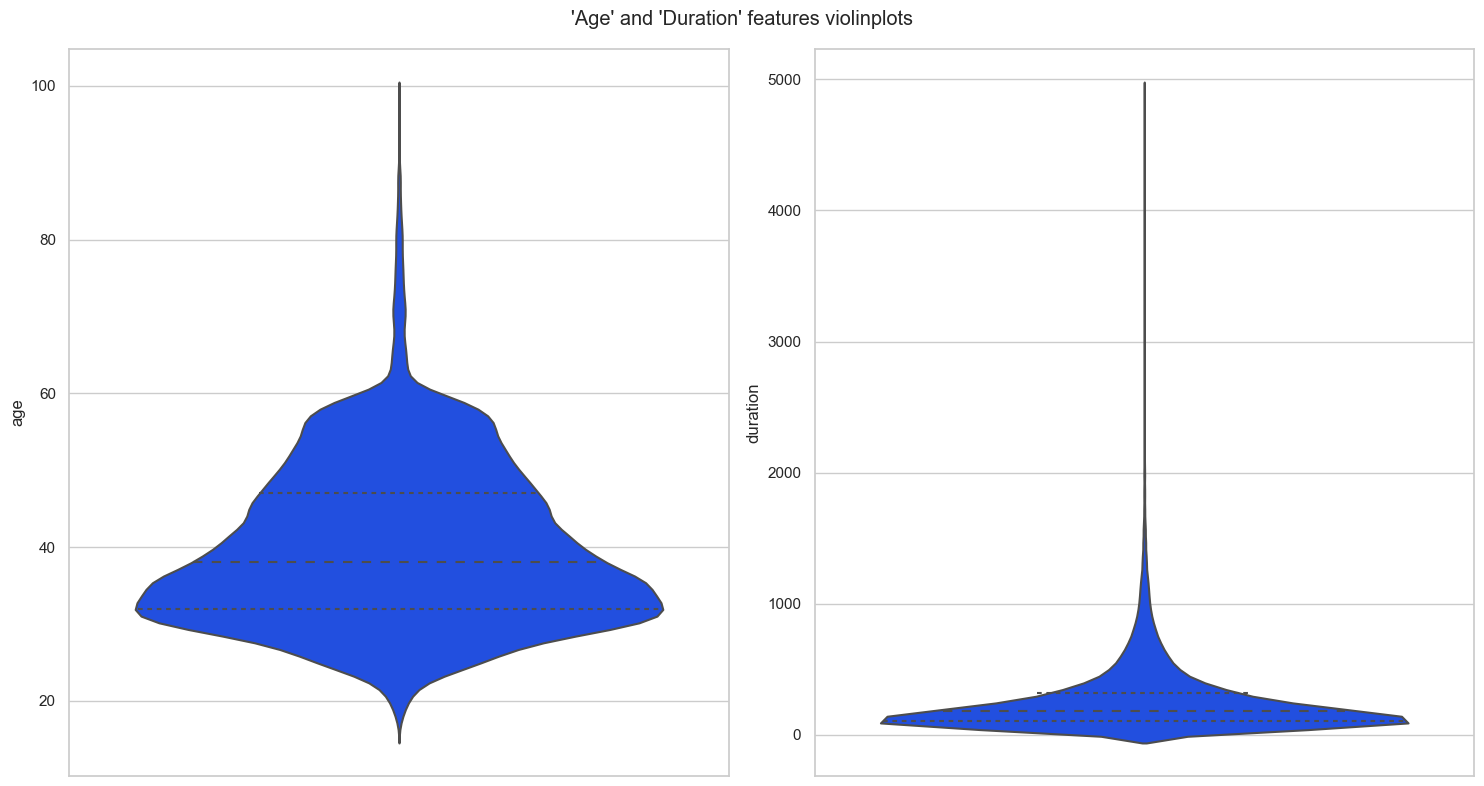

In [42]:
violin_age_duration()

Most individuals in the dataset fall within the age range of approximately 30 to 50. We observe positive skewness in the age and duration features, and a significant positive kurtosis in the distribution of the duration feature.

There are many more values above the upper whisker in the boxplot for the 'duration' feature compared to the 'age' feature.

It's worth mentioning that 75% of the values for the last call duration are less than 320 seconds. On the other hand, the maximum duration for a call was 4918 seconds, which is around 82 minutes—quite impressive!

### Categorical Features

- helper functions for creating count plots for single and multiple features

In [43]:
def cat_countplot(feature, hue=None):
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, hue=hue)
    plt.xticks(rotation=90)
    plt.title(f"Count of '{feature}' Feature Values")
    plt.show()

In [44]:
def grid_cat_countplot(hue=None):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    axes = axes.flatten()

    for i, feature in enumerate(categorical_features[~(categorical_features.isin(["job", "education", "previous_contact"]))]):
        g = sns.countplot(data=df, x=feature, ax=axes[i], order=df[feature].value_counts().index, hue=hue)
        axes[i].tick_params(axis="x", rotation=45)
        g.set(ylabel=None)
    
    plt.suptitle("Count of Categorical Features Values", fontsize=16)
    fig.text(0, 0.5, "Count", va="center", rotation="vertical", fontsize=16)
    plt.tight_layout()
    plt.show()

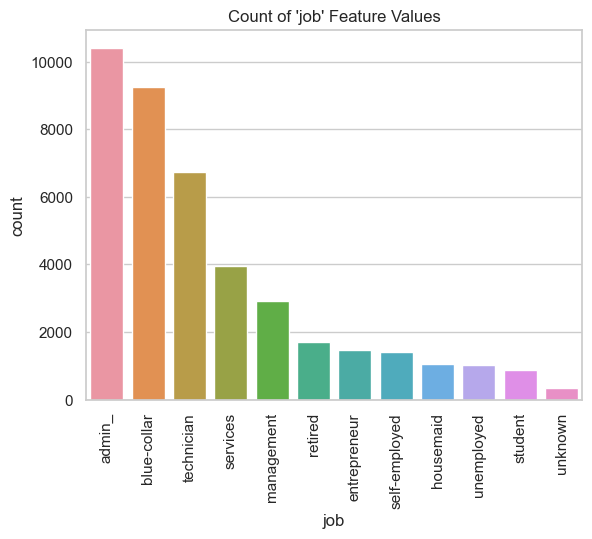

In [45]:
cat_countplot("job")

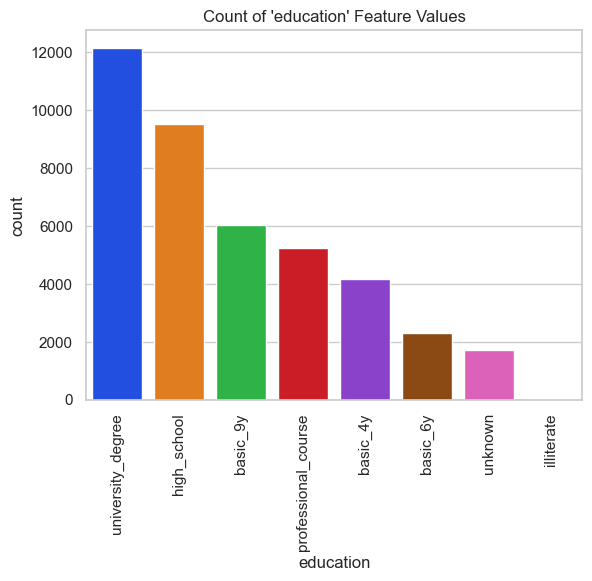

In [46]:
cat_countplot("education")

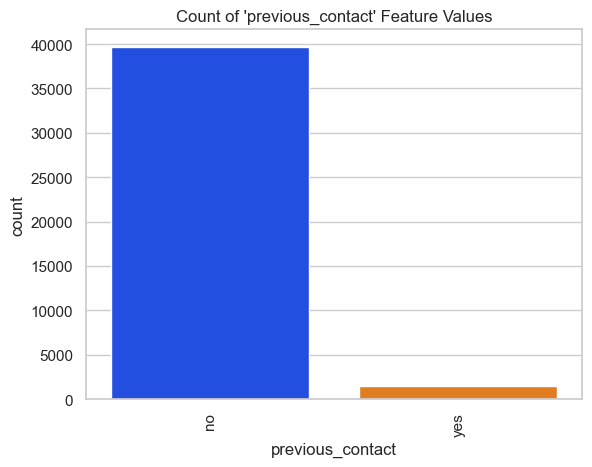

In [47]:
cat_countplot("previous_contact")

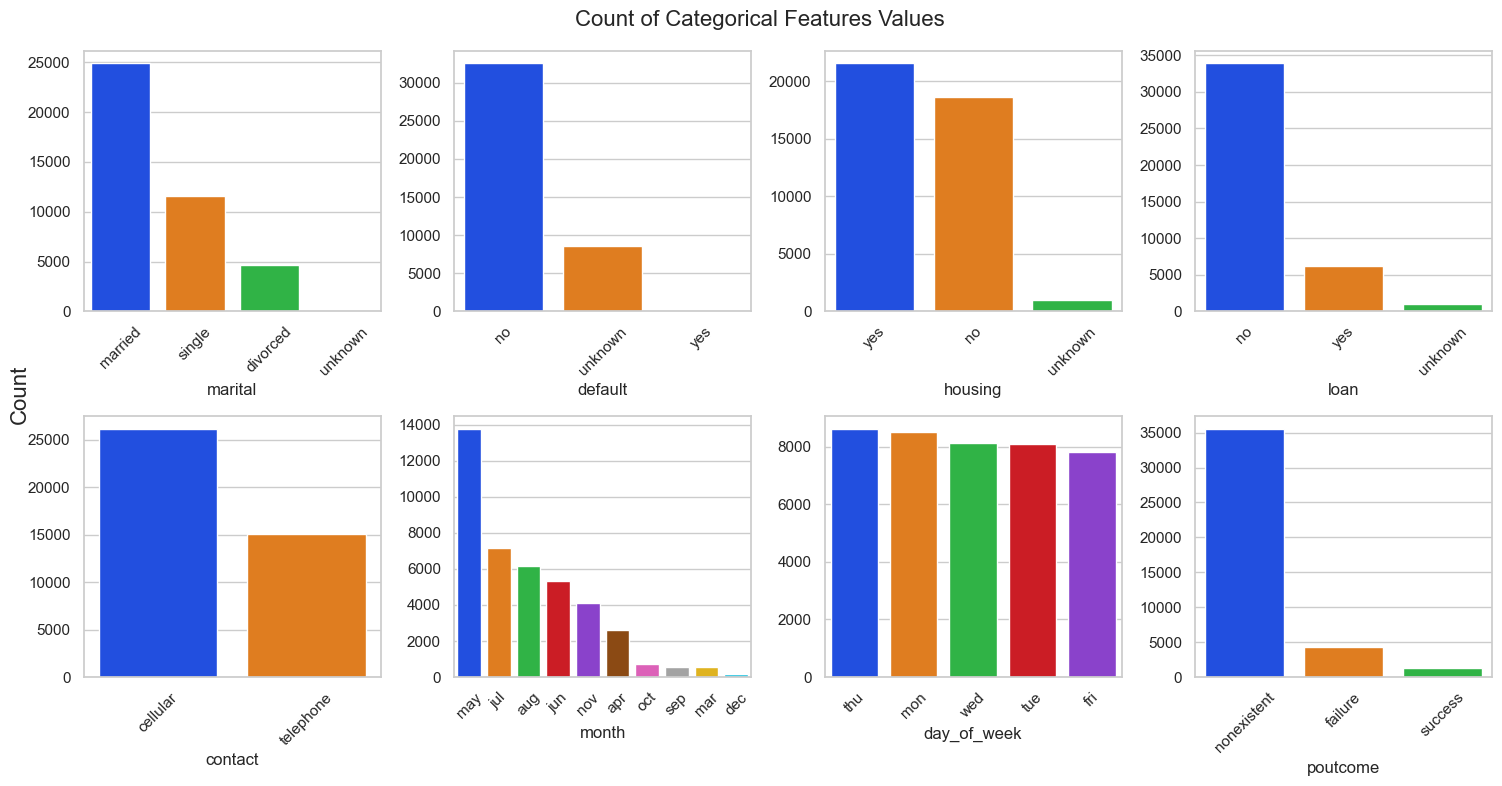

In [48]:
grid_cat_countplot()

Most clients have professional statuses such as 'admin', 'blue-collar' (meaning 'manual worker'), and 'technician'. The unknown status is negligible. The least represented groups are students and unemployed individuals.

Interestingly, around 12 thousand people have higher education, while those with elementary education are a minority in this dataset. It can be concluded that the dataset accurately reflects the real-world scenario where marketing efforts by the bank may be targeted mainly towards educated individuals to achieve desired outcomes.

The majority of last contacts occurred in May, July and August, suggesting that the dataset could have been compiled around the summer.

A larger portion of individuals used mobile phones for contact, did not have a personal loan, and did not have credit in default. Almost exactly half of the individuals have a housing loan.

## Bivariate Analysis

### Numeric vs Numeric (also with target feature hues)

- helper function for plot two numeric features

In [49]:
def plot_two_numeric(feature1, feature2, hue=None):
    sns.jointplot(data=df, x=feature1, y=feature2, hue=hue, marginal_ticks=True)
    plt.show()

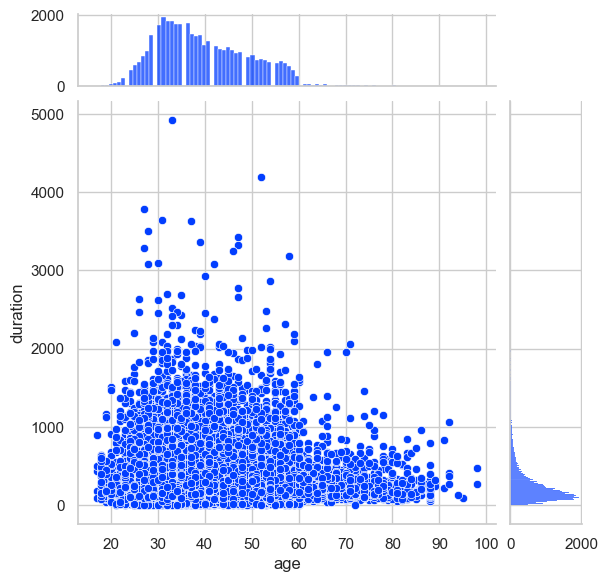

In [50]:
plot_two_numeric("age", "duration")

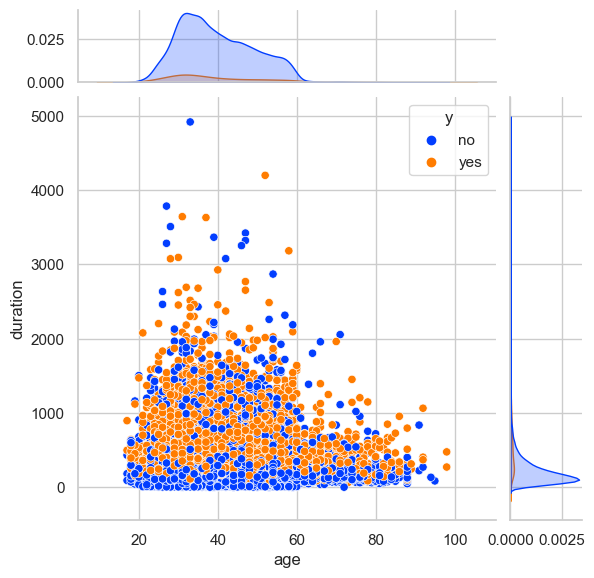

In [51]:
plot_two_numeric("age", "duration", hue="y")

We observe a trend indicating that clients are more likely to subscribe to a term deposit (target feature) when the median of the last contact duration is greater compared to clients who did not subscribe to a term deposit.

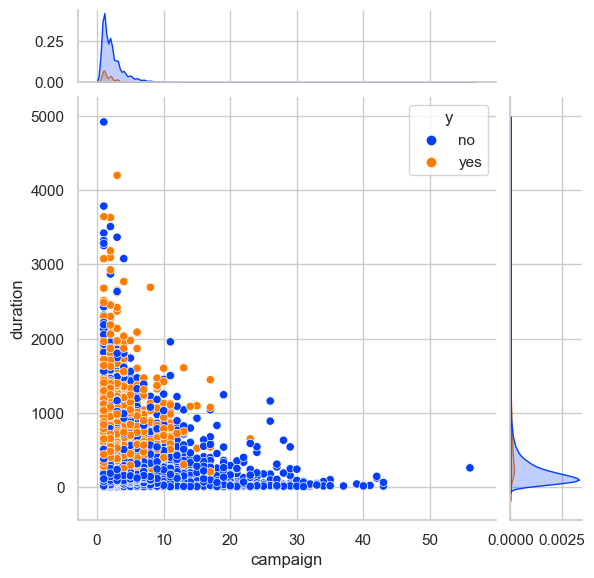

In [52]:
plot_two_numeric("campaign", "duration", hue="y")

We can observe, that on average, a greater number of clients subscribed to a term deposit when the number of contacts performed during this campaign and for this client was less than 15.

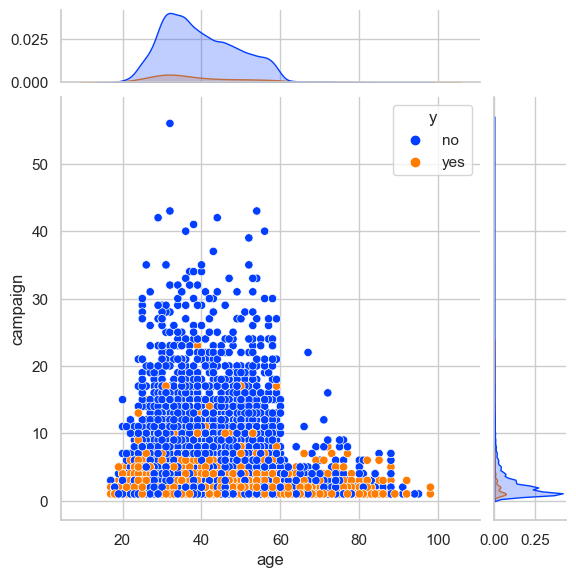

In [53]:
plot_two_numeric("age", "campaign", hue="y")

The lesser number of contacts performed in this campaign was targeted to older people.

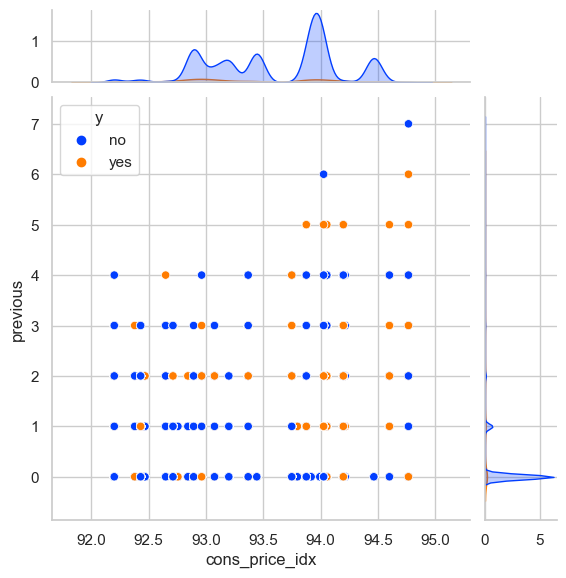

In [54]:
plot_two_numeric("cons_price_idx", "previous", hue="y")

- example of multivariate analysis on numerical features

We can use a pairplot to visualize relationships between features.

/Users/kkozik/Library/anaconda3/envs/psi_env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


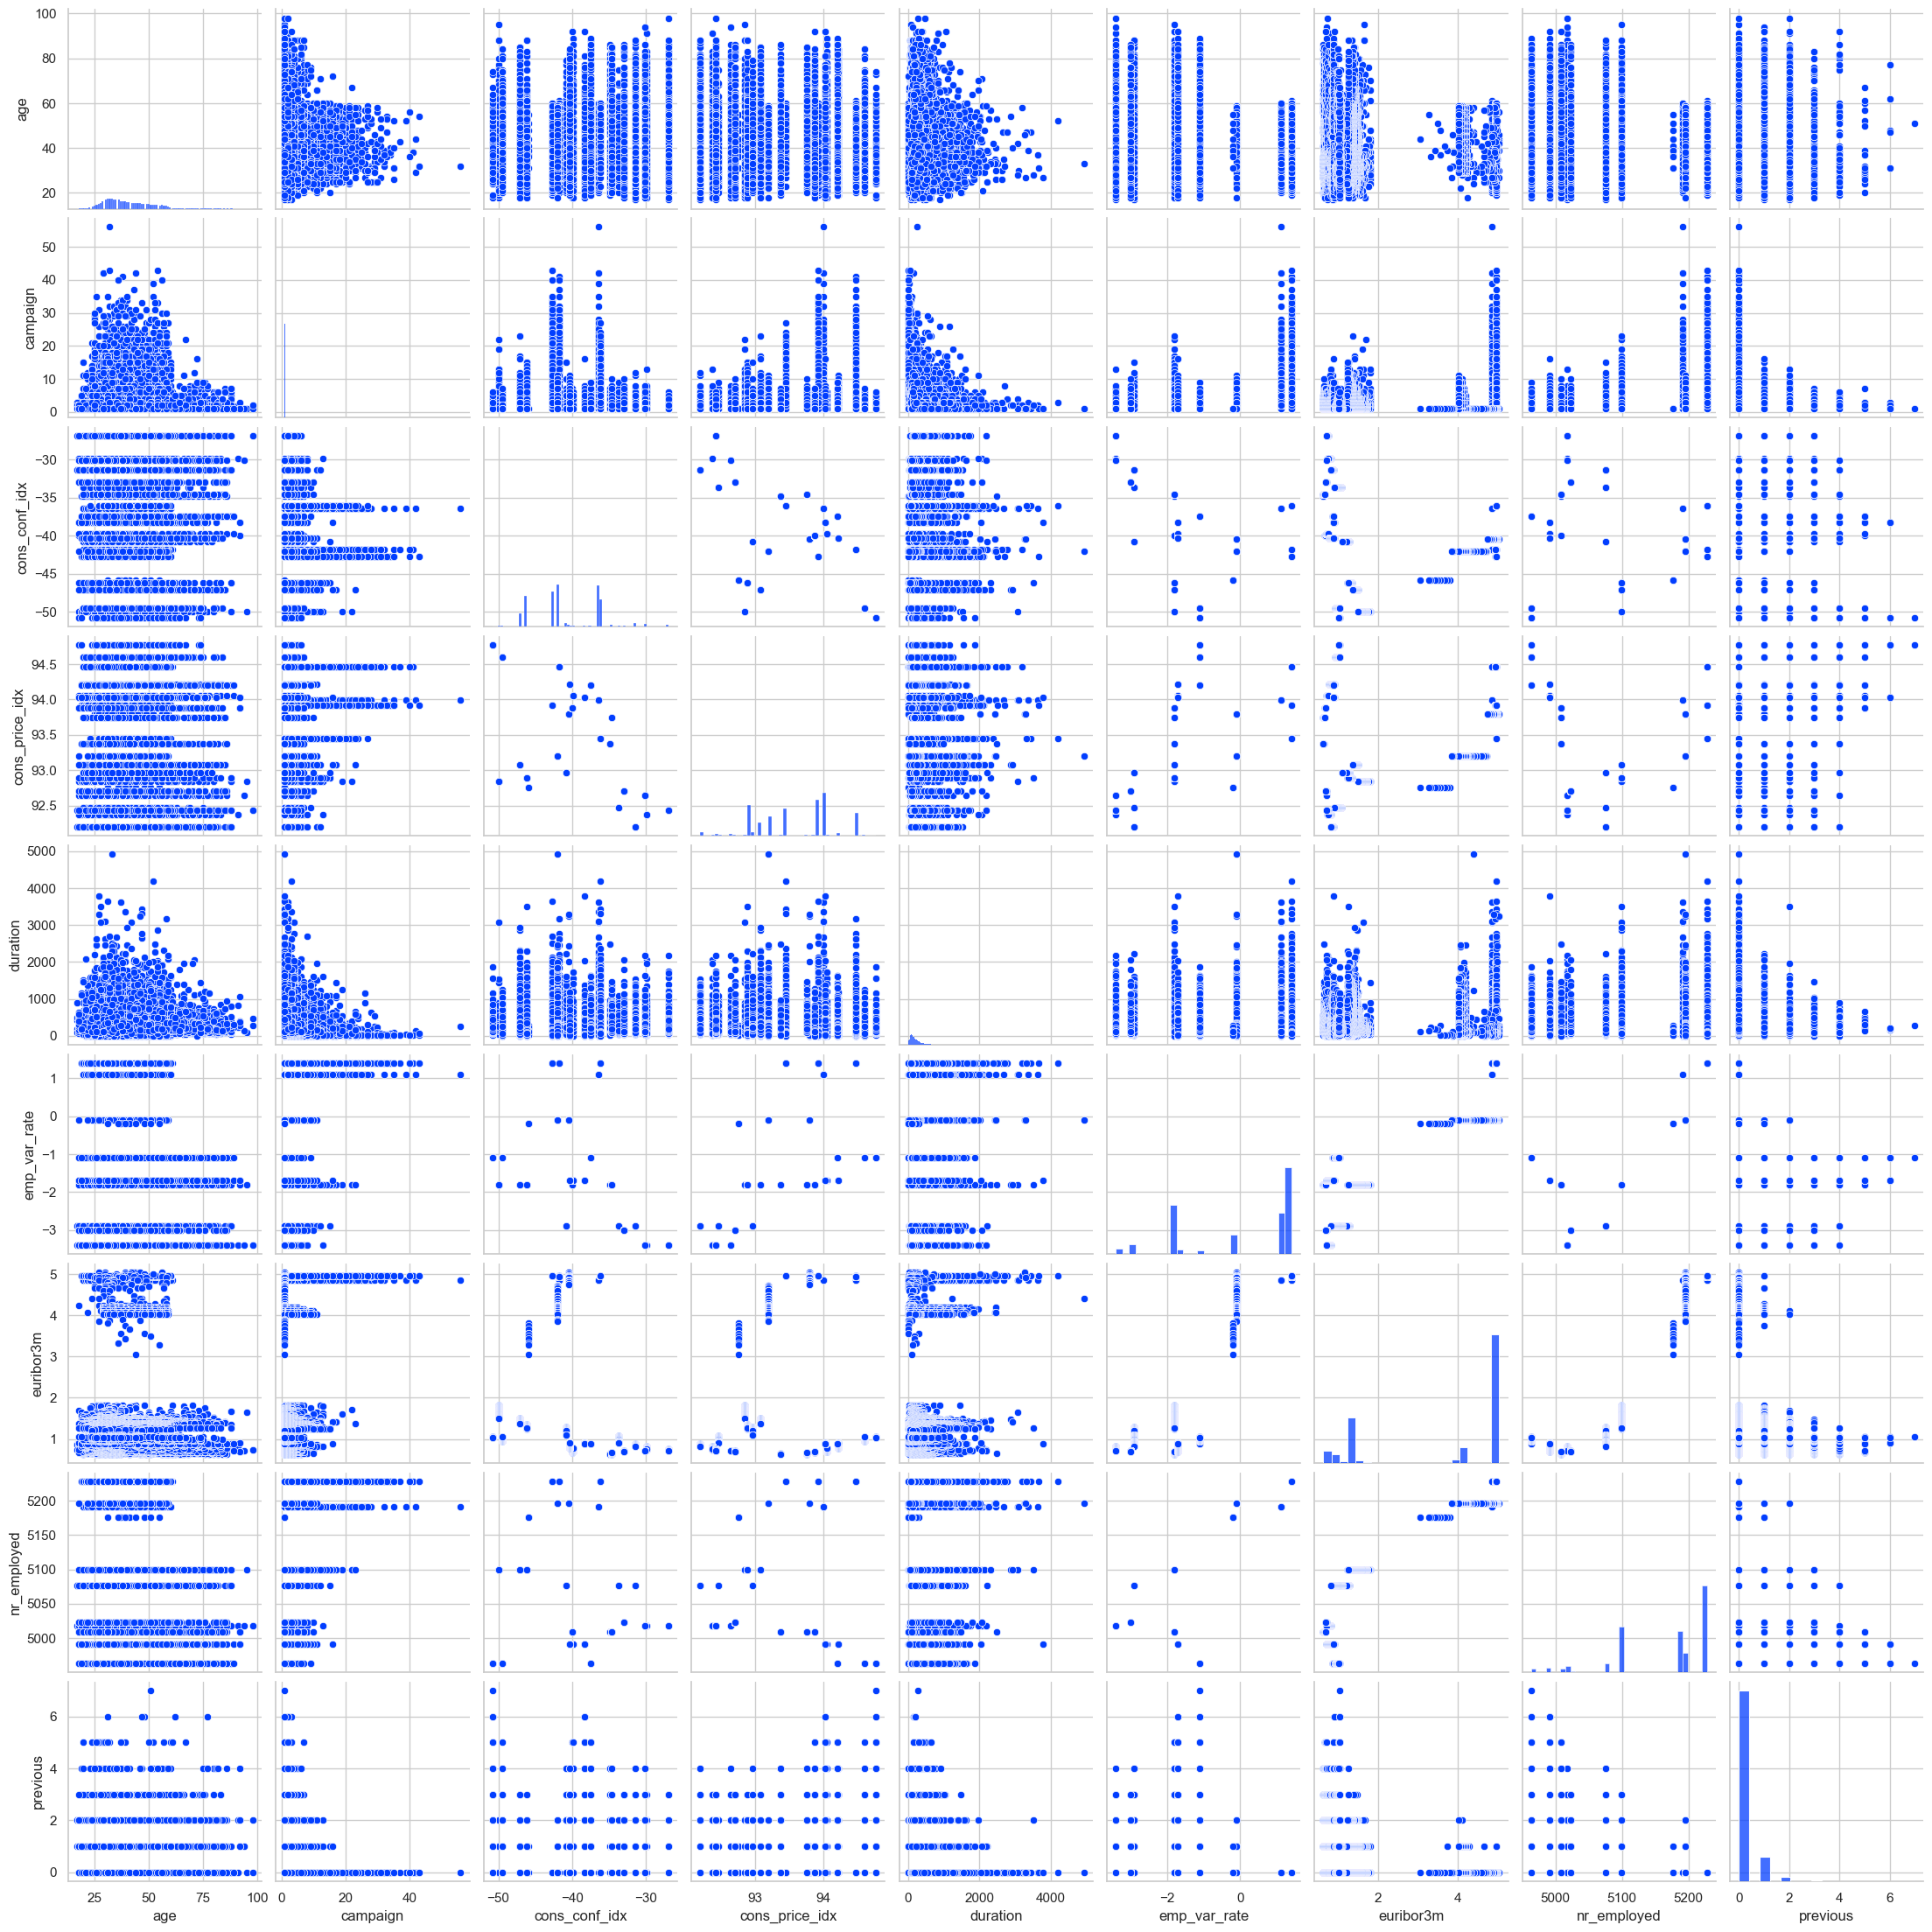

In [55]:
sns.pairplot(df[numerical_features])

### Categorical vs Categorical

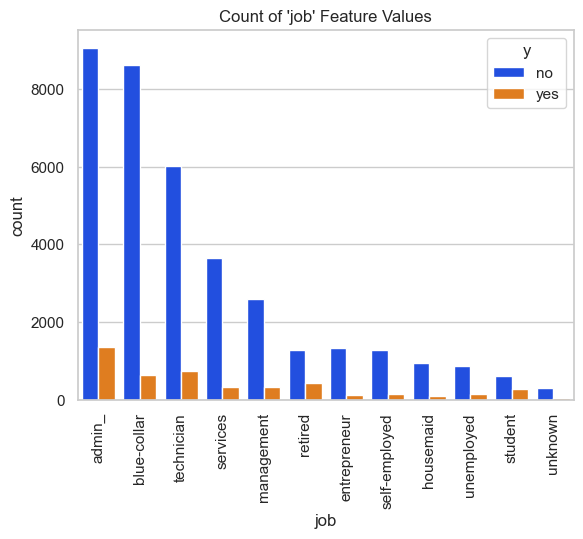

In [56]:
cat_countplot("job", "y")

We can see, that there is a higher proportion of subscriptions to those who are retired or students compared to those who are working.

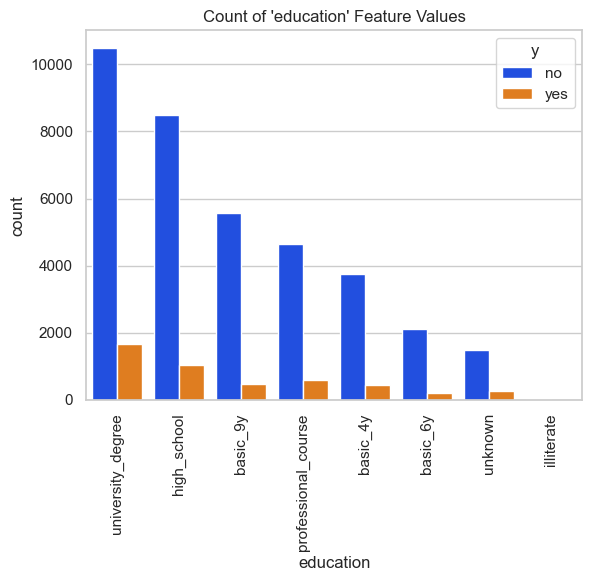

In [57]:
cat_countplot("education", "y")

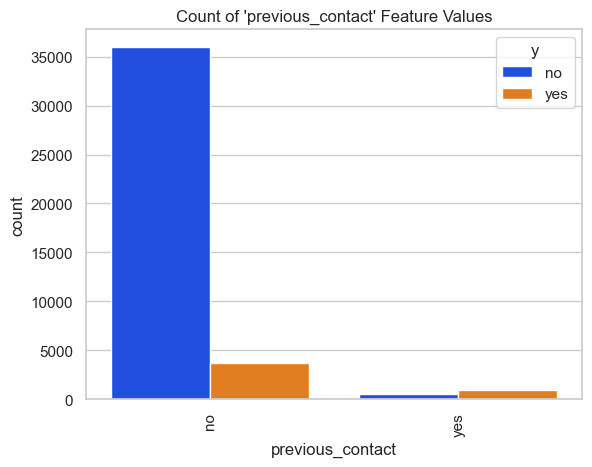

In [58]:
cat_countplot("previous_contact", "y")

Interestingly, there are more samples of clients who subscribed to a term deposit after being contacted in the previous campaign.

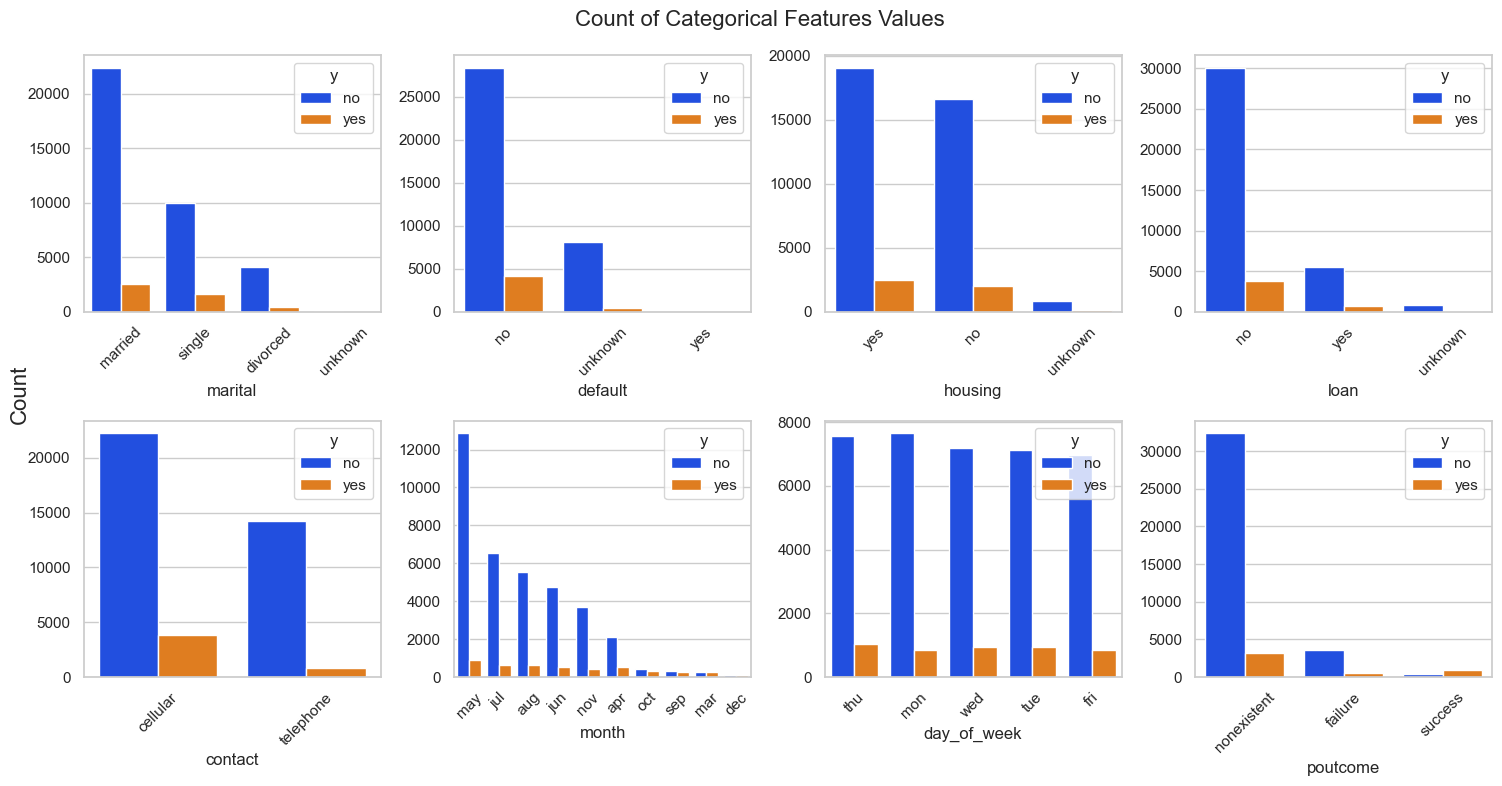

In [59]:
grid_cat_countplot("y")

- helper function to create a cross-tabulation between two features

In [60]:
def crosstab(feature1, feature2):
    sns.heatmap(pd.crosstab(df[feature1], df[feature2]), annot=True, fmt=".0f", 
                vmin=0, cmap="coolwarm", linecolor="white", linewidths=1)
    plt.title(f"Crosstab table: '{feature1}' vs '{feature2}'")
    plt.show()

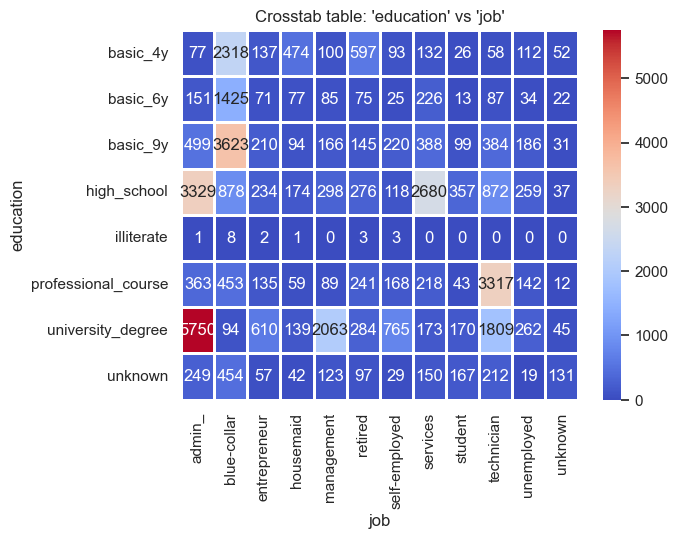

In [61]:
crosstab("education", "job")

Significantly more clients have administrative professional statuses and higher education. The second-largest group consists of manual workers with basic education, and the third-largest group consists of technicians with professional courses. The smallest group of people is those who are illiterate.

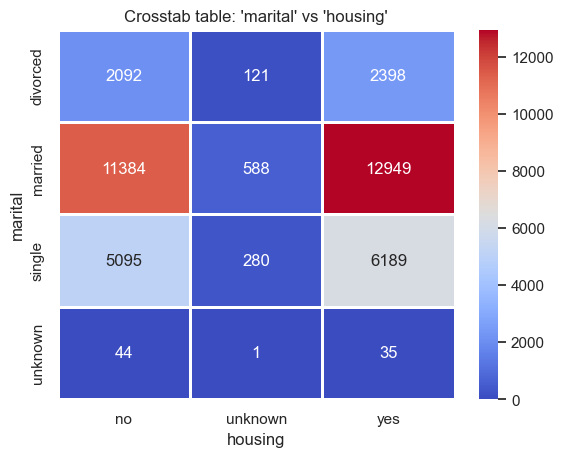

In [62]:
crosstab("marital", "housing")

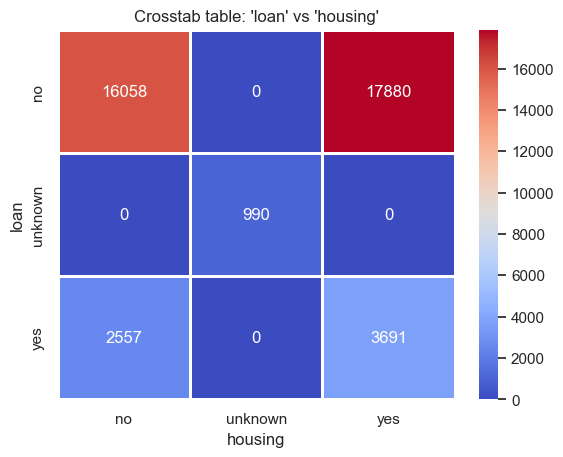

In [63]:
crosstab("loan", "housing")

More people haven't got a personal loan, and there are more with a housing loan.

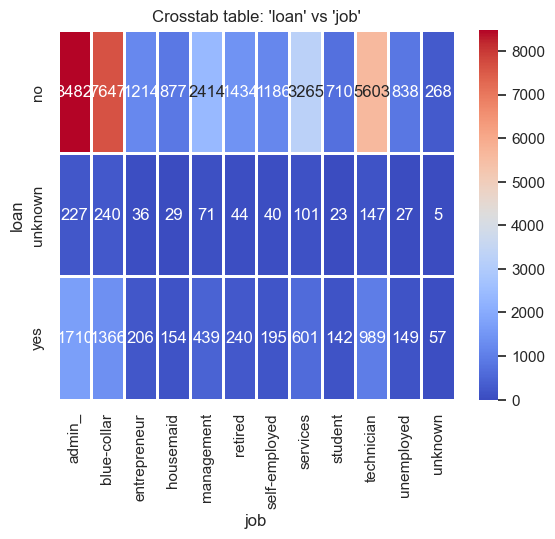

In [64]:
crosstab("loan", "job")

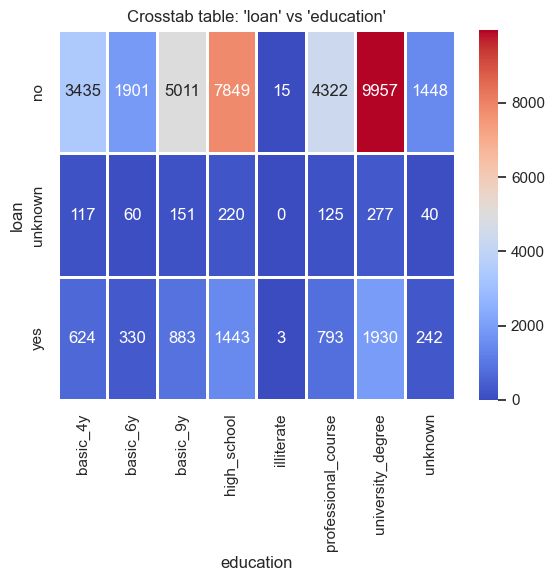

In [65]:
crosstab("loan", "education")

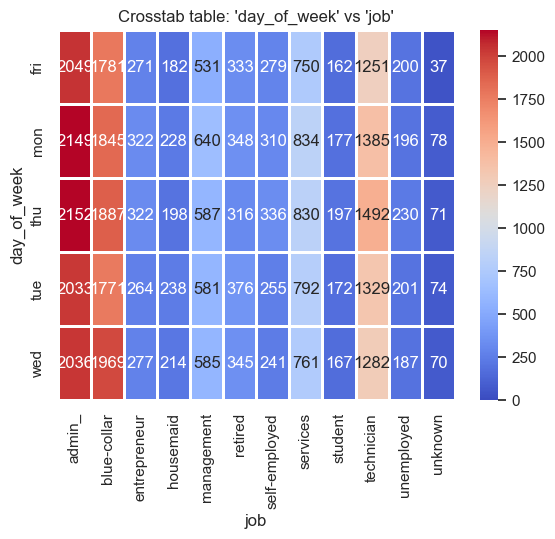

In [66]:
crosstab("day_of_week", "job")

We can see that the last contact's day of the week doesn't have an impact on the types of jobs where people work.

### Numeric vs Categorical

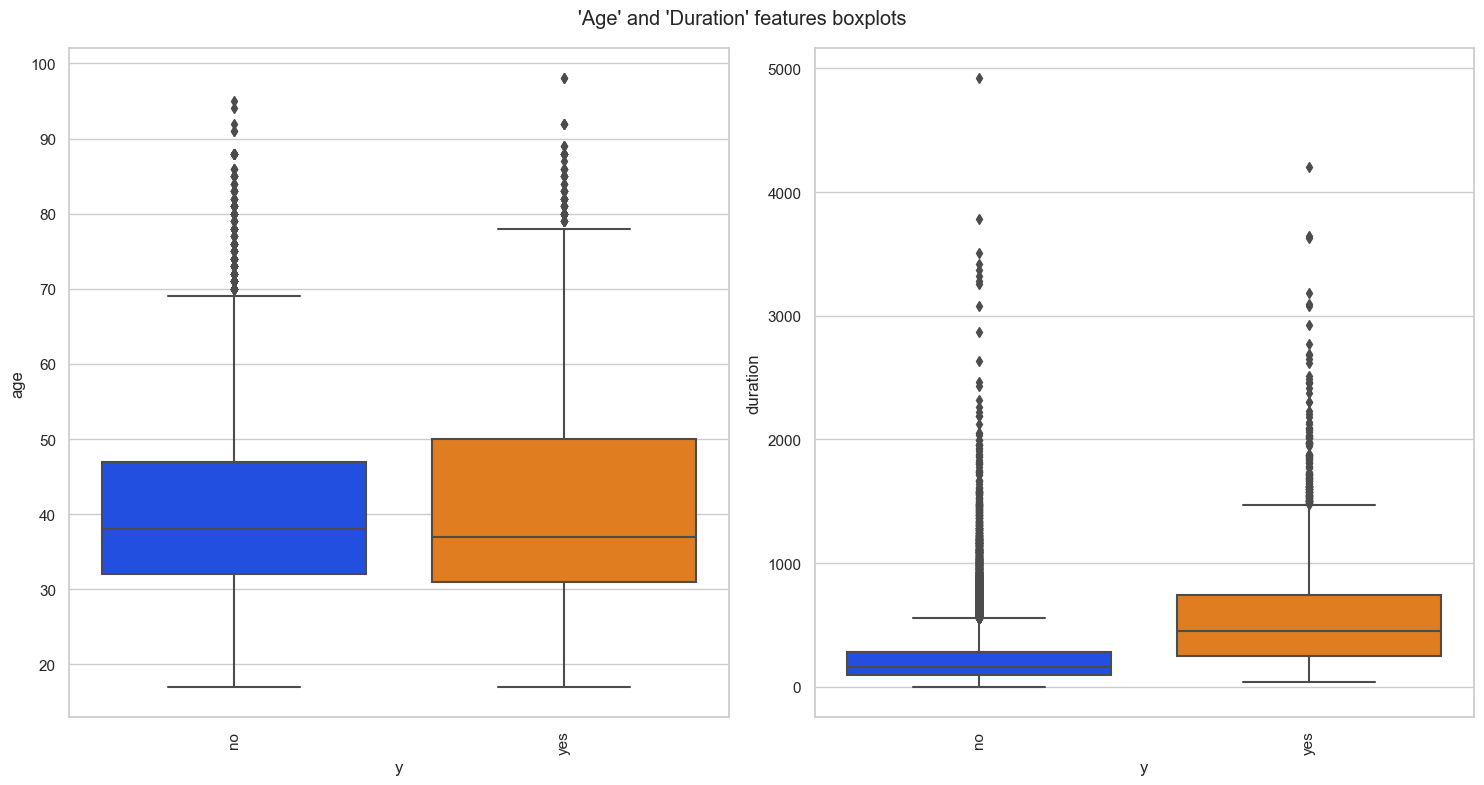

In [67]:
boxplot_age_duration(x="y")

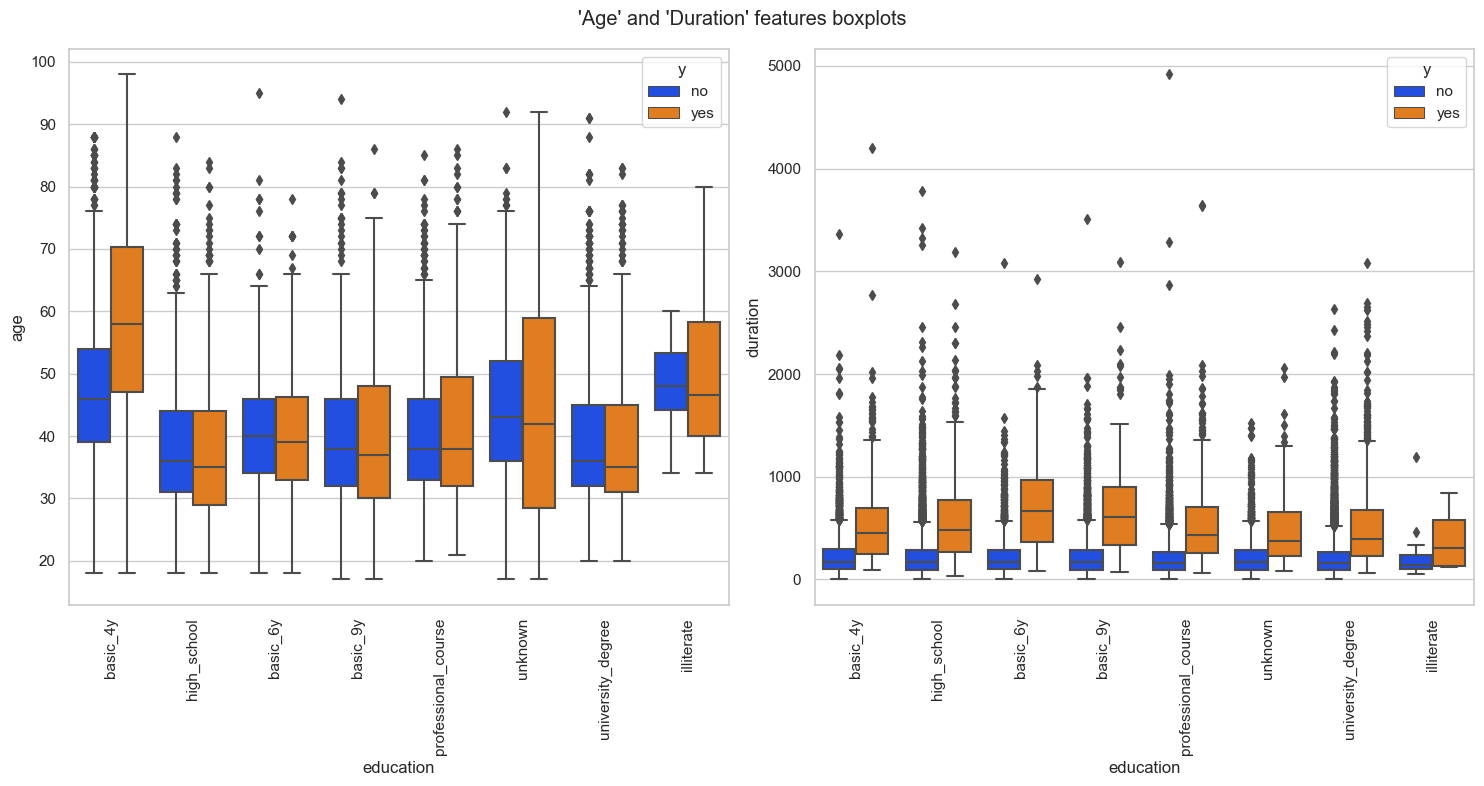

In [68]:
boxplot_age_duration(x="education", hue="y")

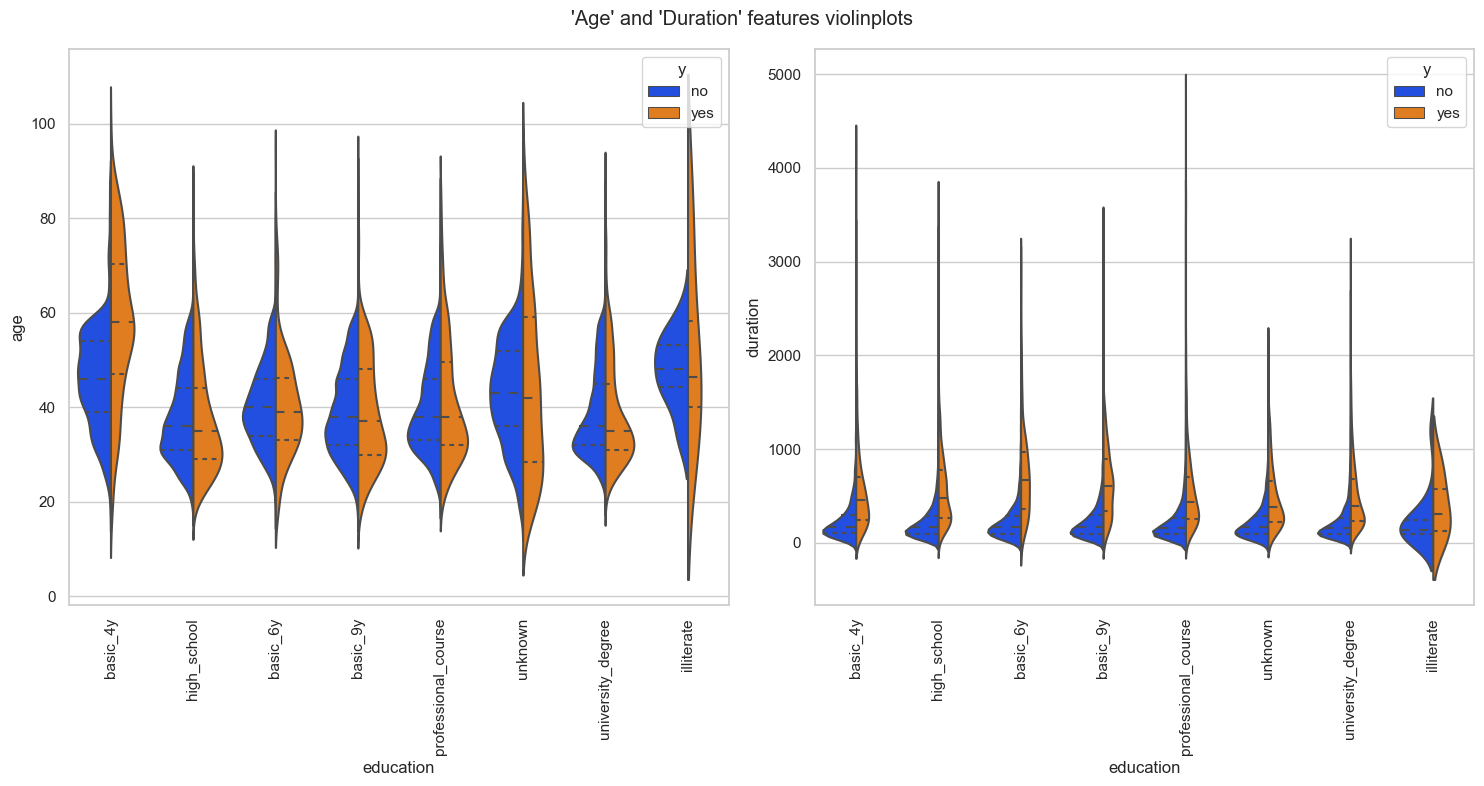

In [69]:
violin_age_duration(x="education", hue="y")

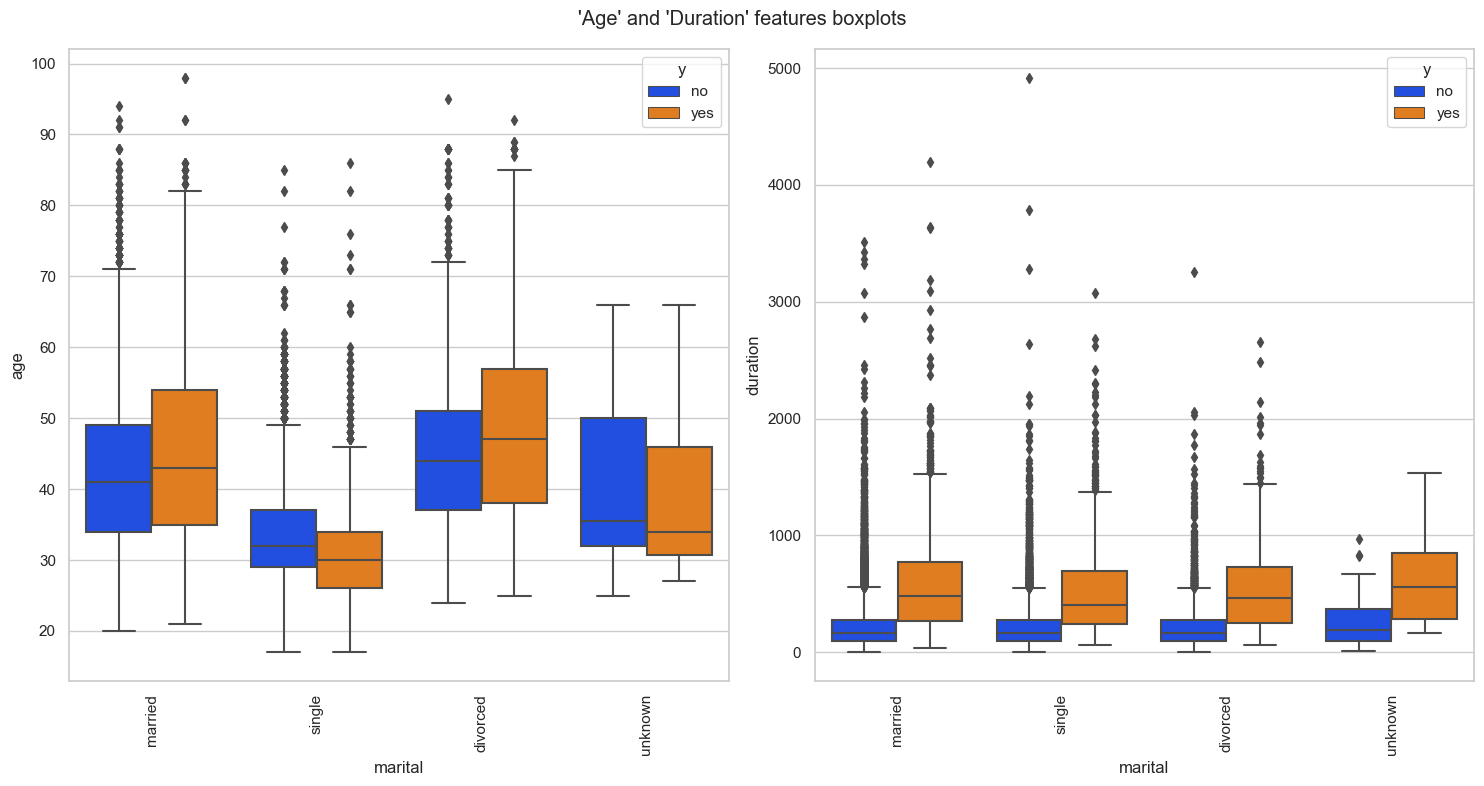

In [70]:
boxplot_age_duration(x="marital", hue="y")

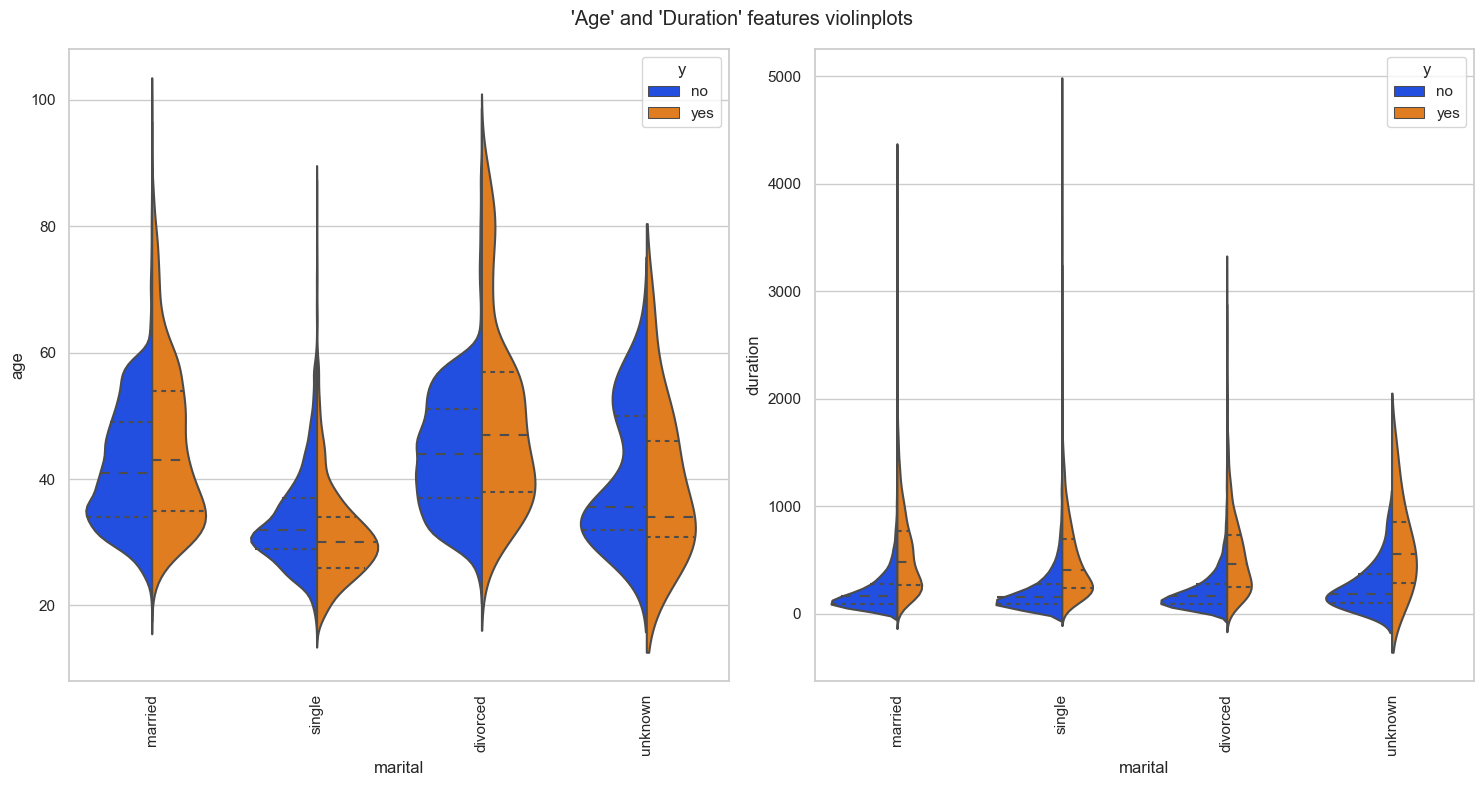

In [71]:
violin_age_duration(x="marital", hue="y")

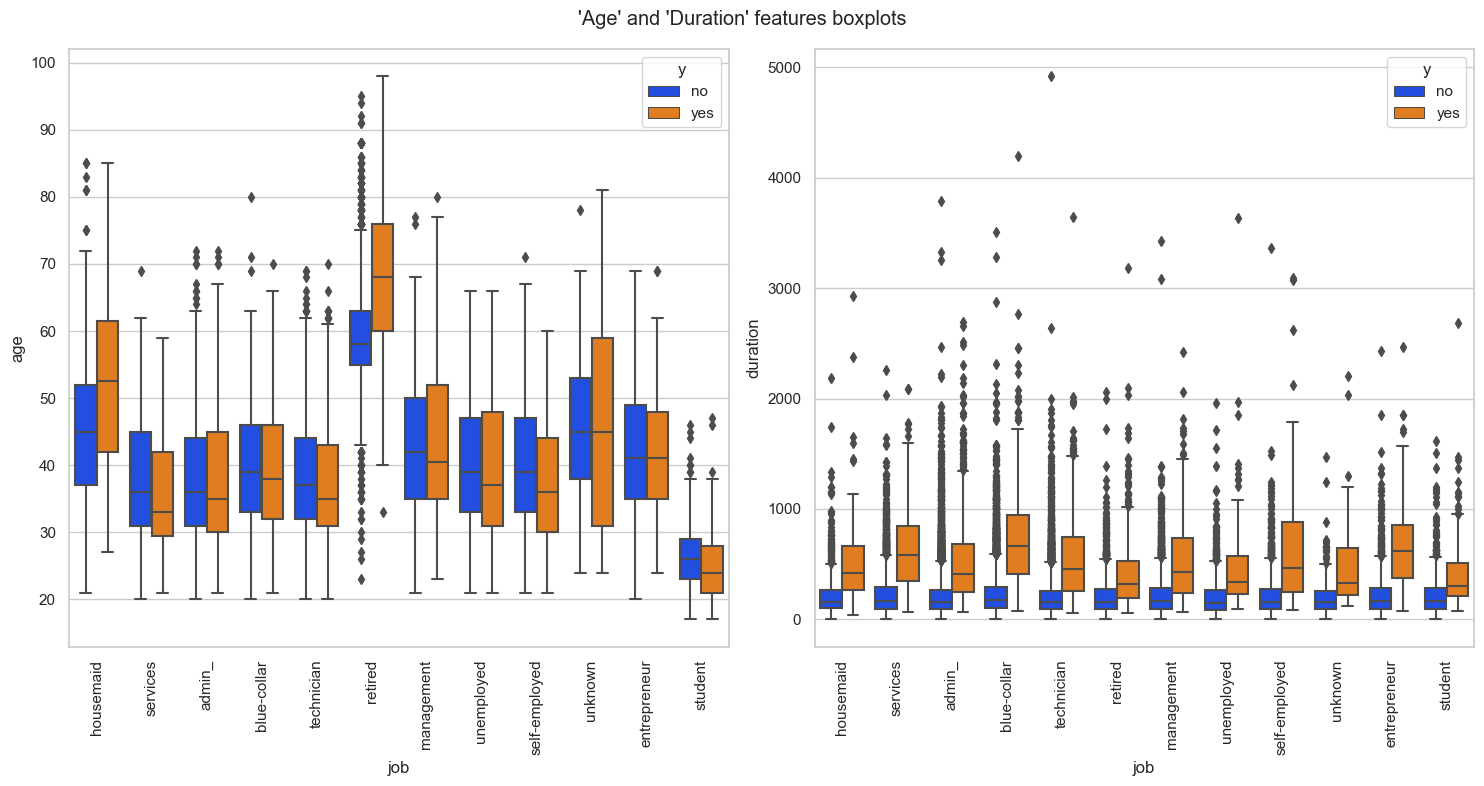

In [72]:
boxplot_age_duration(x="job", hue="y")

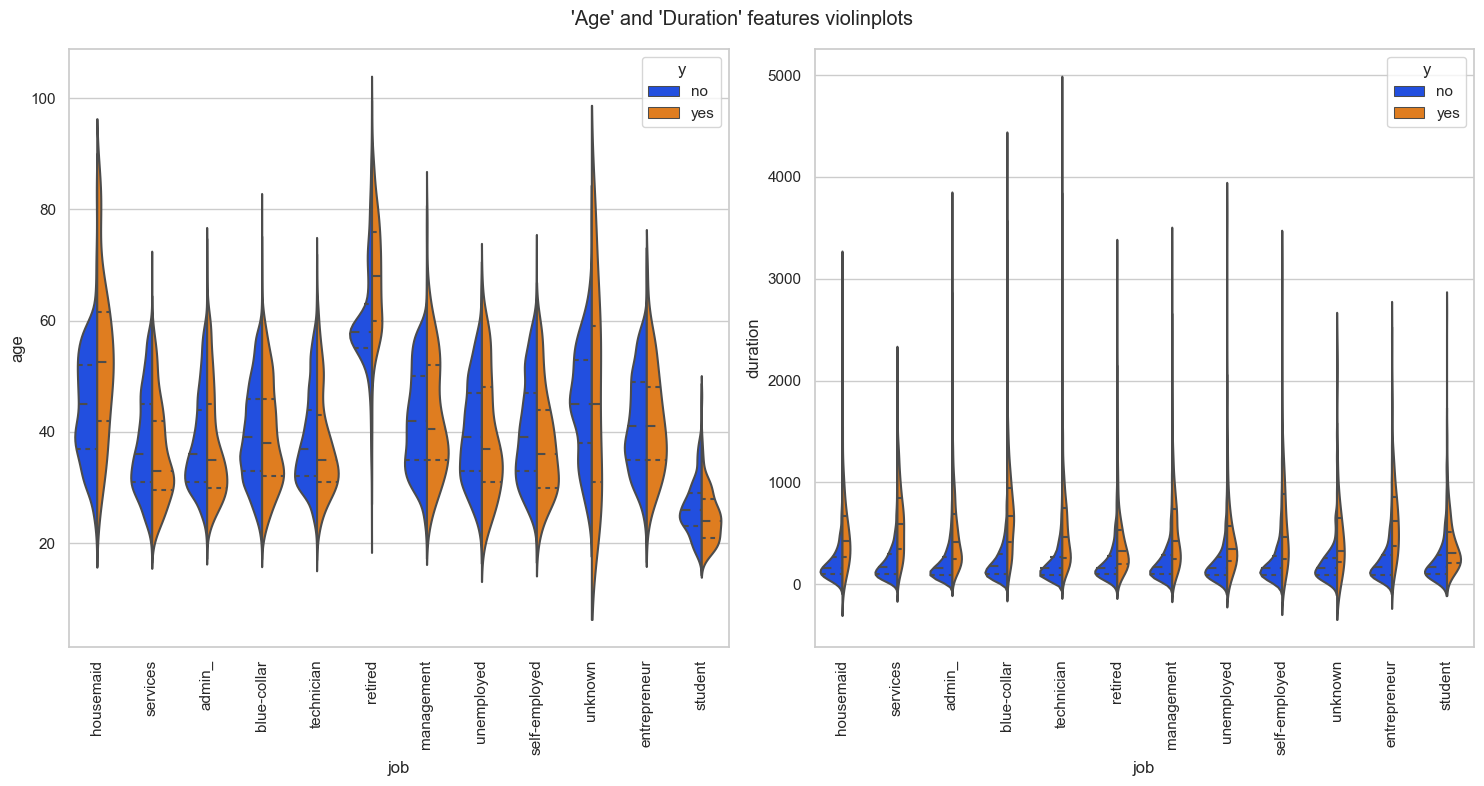

In [73]:
violin_age_duration(x="job", hue="y")

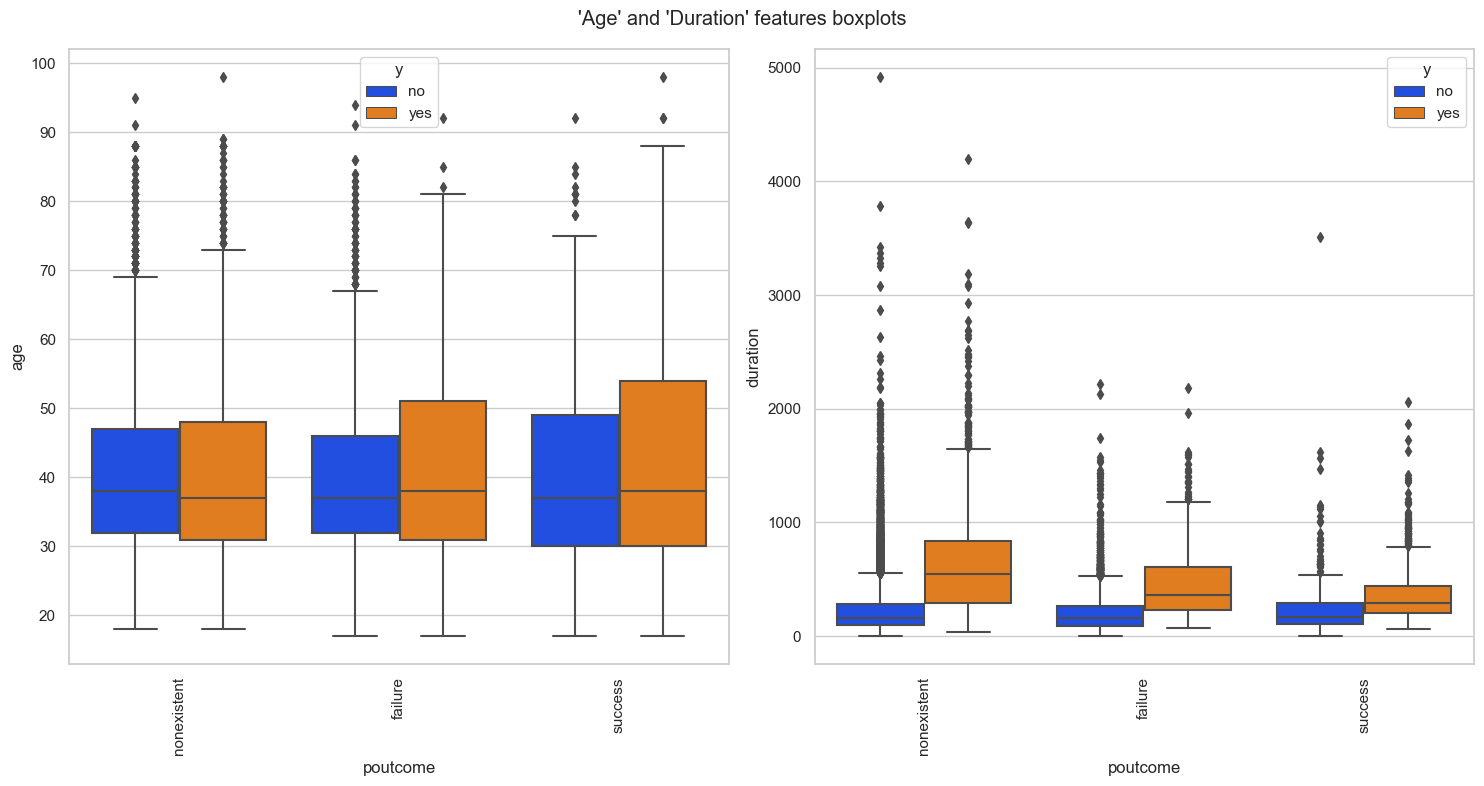

In [74]:
boxplot_age_duration(x="poutcome", hue="y")

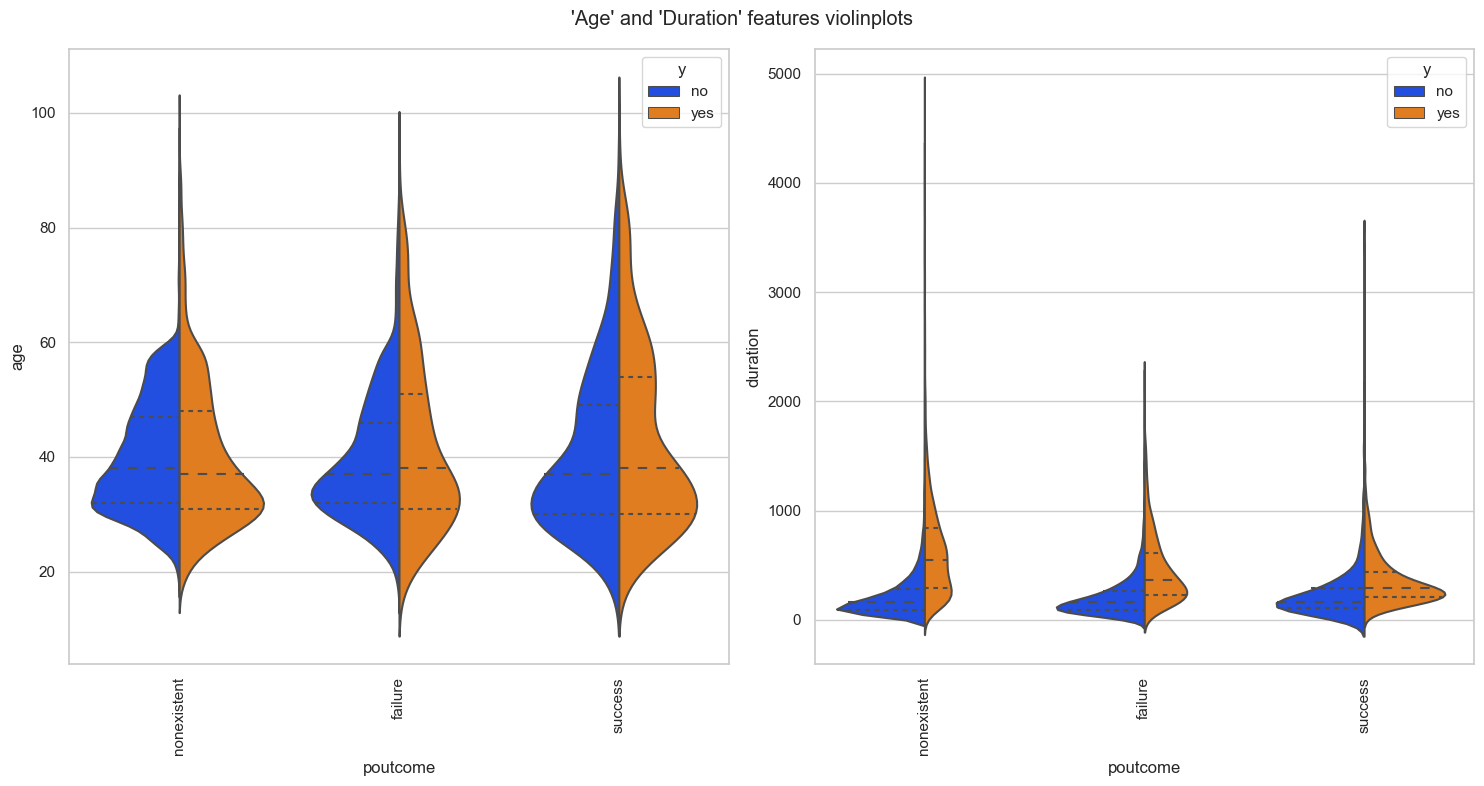

In [75]:
violin_age_duration(x="poutcome", hue="y")

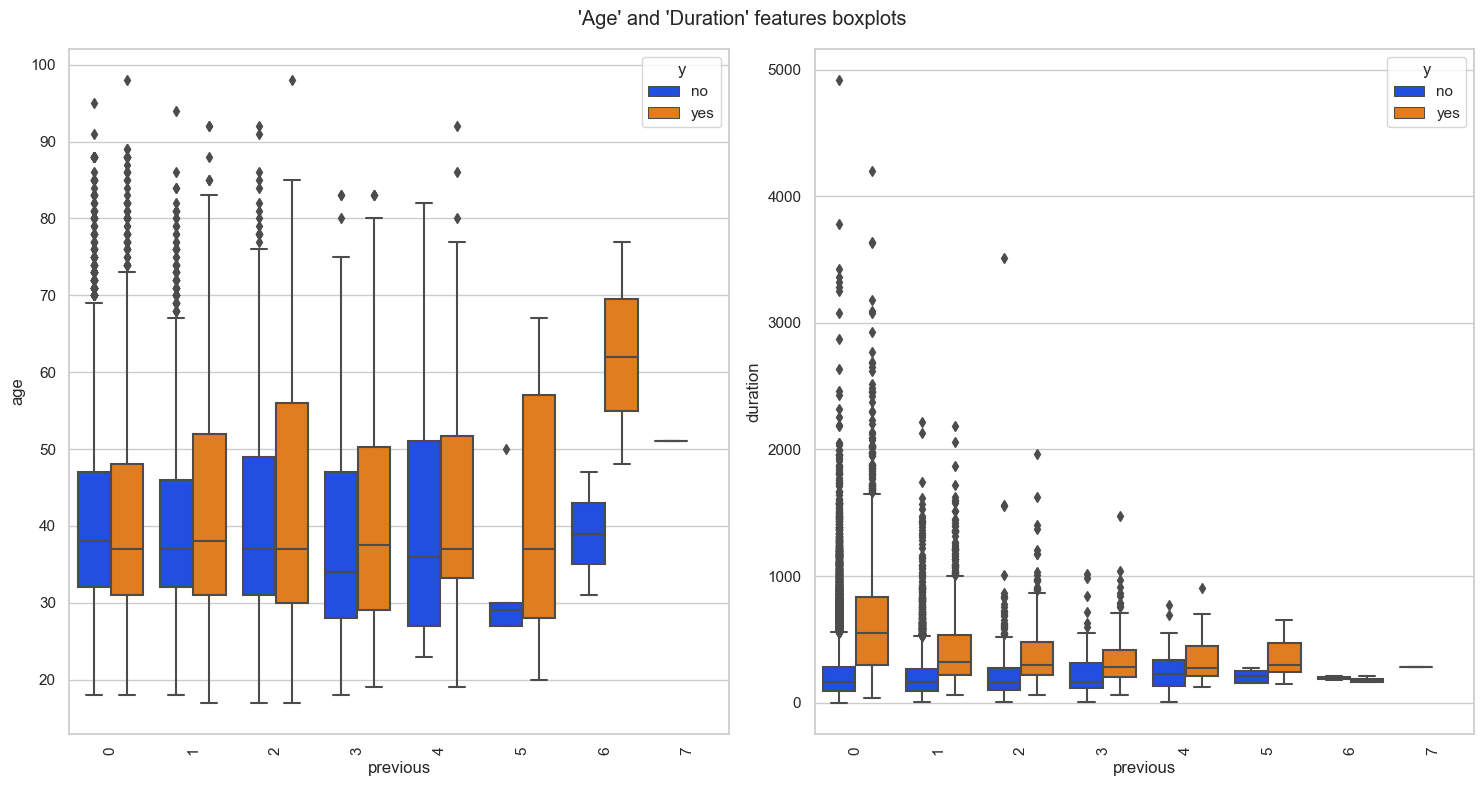

In [76]:
boxplot_age_duration(x="previous", hue="y")

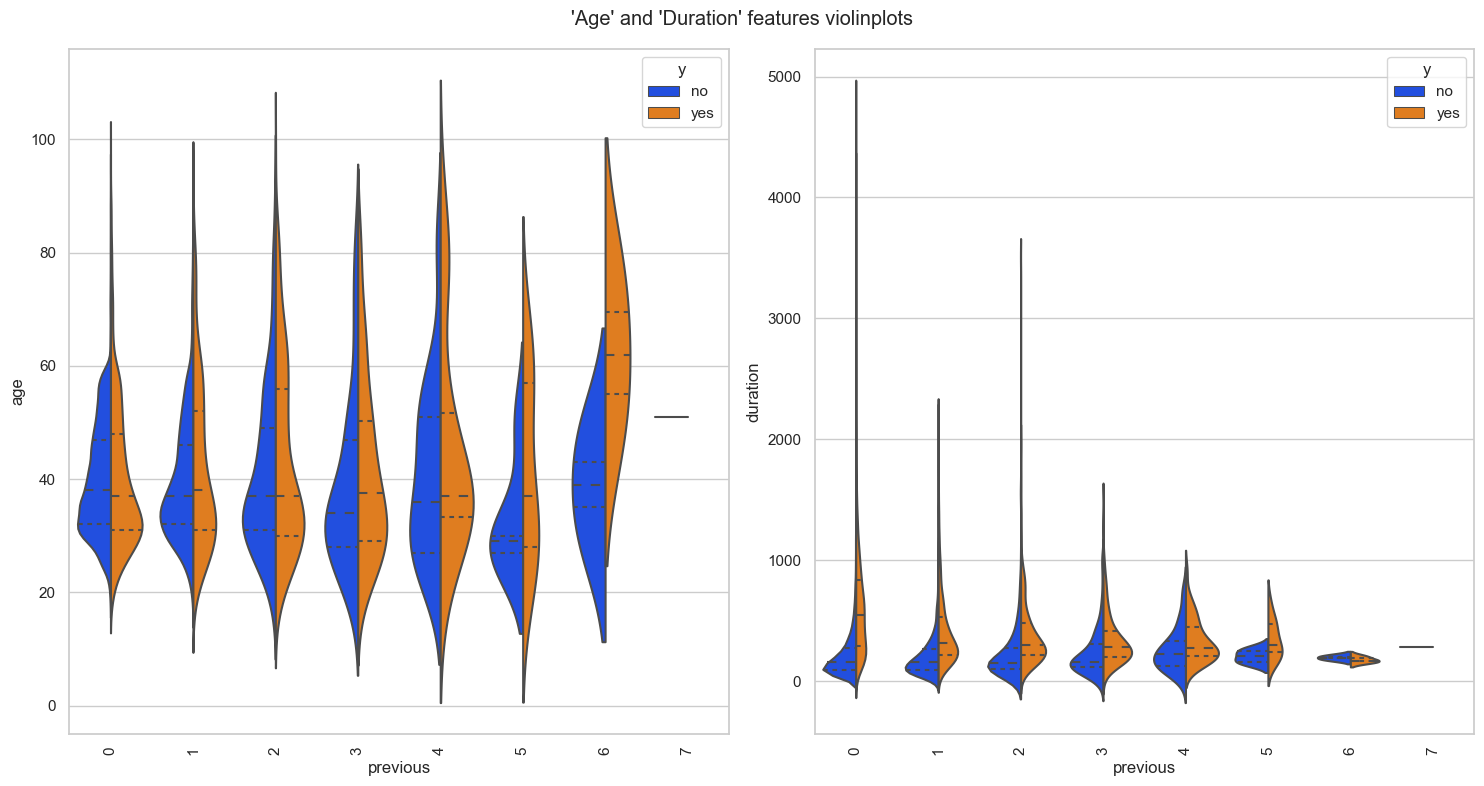

In [77]:
violin_age_duration(x="previous", hue="y")

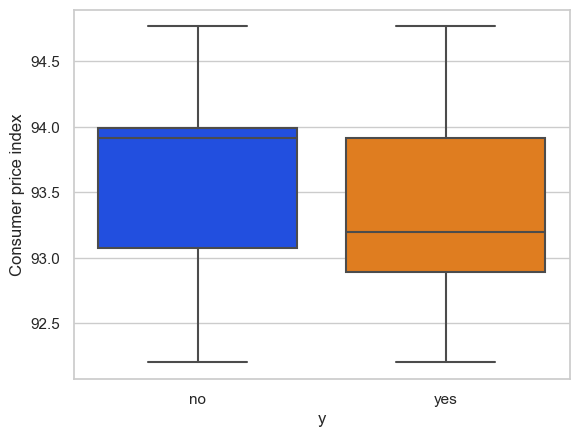

In [78]:
sns.boxplot(data=df, x="y",y="cons_price_idx")
plt.ylabel("Consumer price index")
plt.show()

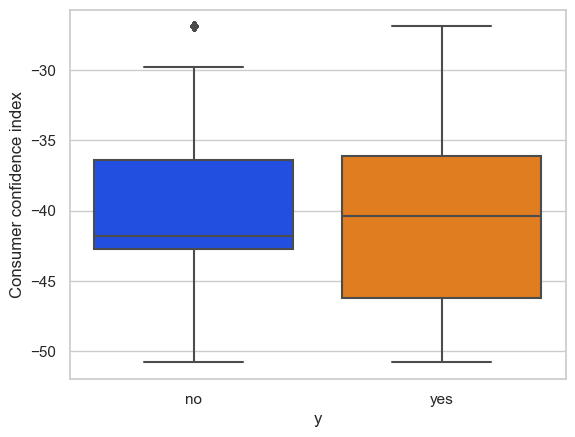

In [79]:
sns.boxplot(data=df, x="y",y="cons_conf_idx")
plt.ylabel("Consumer confidence index")
plt.show()

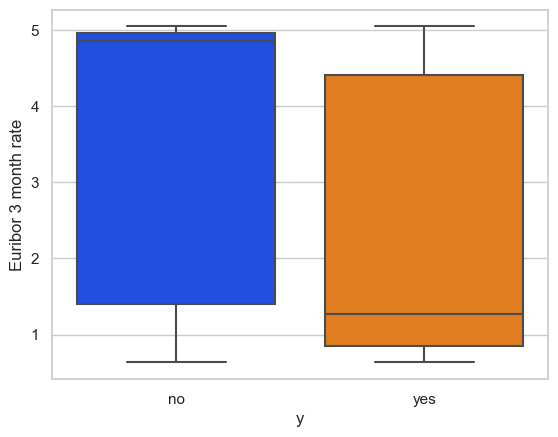

In [80]:
sns.boxplot(data=df, x="y",y="euribor3m")
plt.ylabel("Euribor 3 month rate")
plt.show()

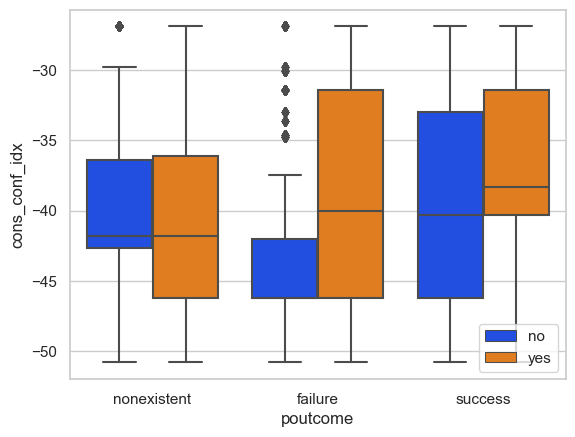

In [81]:
sns.boxplot(data=df, x="poutcome", y="cons_conf_idx", hue="y")
plt.legend(loc="lower right")
plt.show()

Some observations about boxplots and violinplots in the 'Numeric vs Categorical' section:

- higher median and IQR for the last call duration for people who subscribed to a term deposit,
- higher median of the age of individuals with basic 4-year education who subscribed to a term deposit,
- higher median and IQR for the age of housemaids and retirees who subscribed to a term deposit,
- the number of individuals who subscribed to a term deposit was contacted a greater number of times previously, and this was more prevalent among older individuals,
- and so on...

## Multivariate Analysis

### Correlation Matrix

- Pearson Correlation Coefficient 

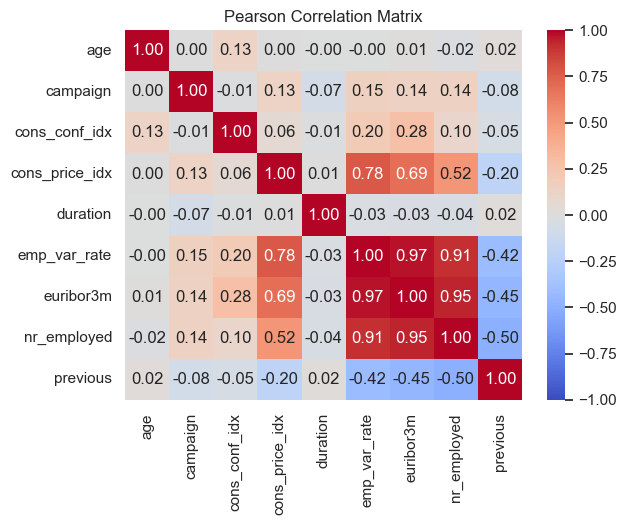

In [82]:
sns.heatmap(df[numerical_features].corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Pearson Correlation Matrix")
plt.show()

- Spearman Correlation Coefficient 

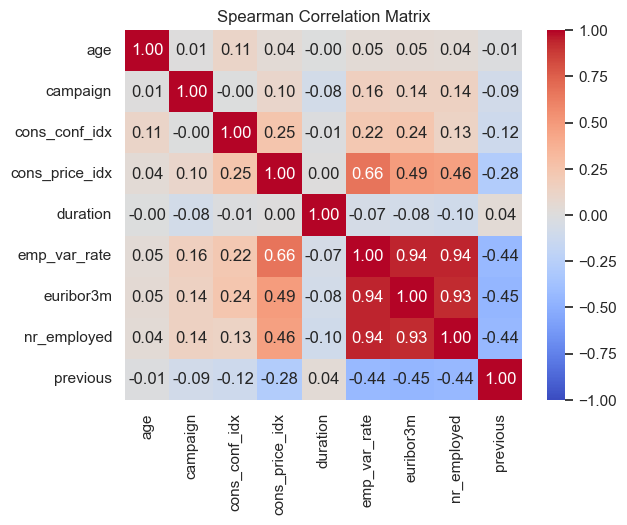

In [83]:
sns.heatmap(df[numerical_features].corr(method="spearman"), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Spearman Correlation Matrix")
plt.show()

- Kendall Correlation Coefficient 

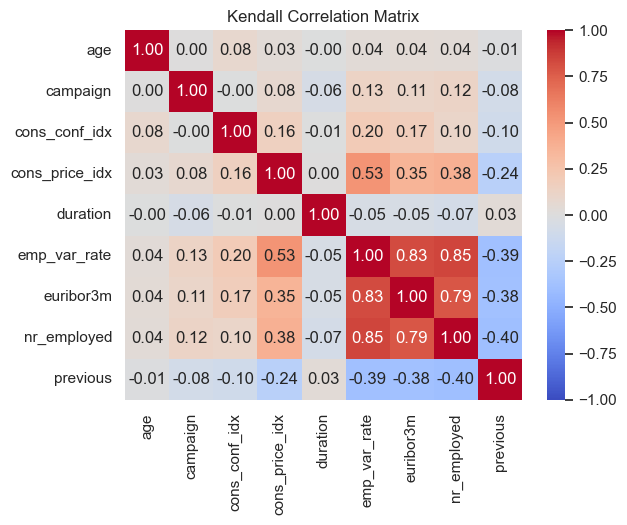

In [84]:
sns.heatmap(df[numerical_features].corr(method="kendall"), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Kendall Correlation Matrix")
plt.show()

Based on observations from these three heatmaps, there is a high correlation between:
- employment variation rate and euribor 3 month rate
- employment variation rate and number of employees
- euribor3m and number of employees
- employment variation rate and consumer price index

Deleting some features from these combinations of correlation coefficients, for example, the employment variation rate and euribor 3-month rate features, will be necessary for some machine learning models to improve their quality. Preserving the features associated with the number of employees and the consumer price index is of significant importance for this dataset, as they play a crucial role in understanding workforce dynamics and economic trends.

In [85]:
df.drop(columns=["euribor3m", "emp_var_rate"], inplace=True)

In [86]:
numerical_features

0               age
1          campaign
2     cons_conf_idx
3    cons_price_idx
4          duration
5      emp_var_rate
6         euribor3m
7       nr_employed
8          previous
dtype: object

In [87]:
numerical_features.drop(index=[5, 6], inplace=True)
numerical_features.reset_index(drop=True, inplace=True)

Once again we can check correlation matrix:

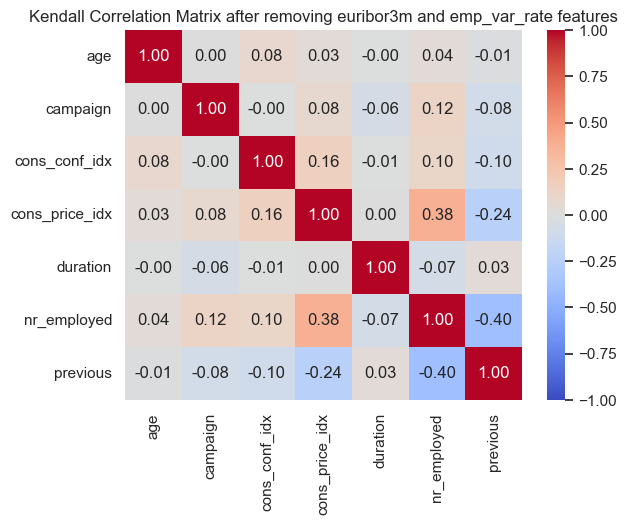

In [88]:
sns.heatmap(df[numerical_features].corr(method="kendall"), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Kendall Correlation Matrix after removing euribor3m and emp_var_rate features")
plt.show()

---

# Data Preparation

As previously mentioned, rows containing NaN values for five categorical features with a negligible amount should be removed. First of all, we will replace unknown category with NaN value, to use previously defined method to count missing values and use built-in function to remove rows.

In [89]:
df[["education", "housing", 
    "loan", "job", "marital"]] = df[["education", "housing", 
                                     "loan", "job", "marital"]].replace("unknown", np.NaN)
df.head(10).T

0            1            2            3  \
age                        56           57           37           40   
job                 housemaid     services     services       admin_   
marital               married      married      married      married   
education            basic_4y  high_school  high_school     basic_6y   
default                    no      unknown           no           no   
housing                    no           no          yes           no   
loan                       no           no           no           no   
contact             telephone    telephone    telephone    telephone   
month                     may          may          may          may   
day_of_week               mon          mon          mon          mon   
duration                  261          149          226          151   
campaign                    1            1            1            1   
previous                    0            0            0            0   
poutcome          nonexistent  nonexistent  nonexistent  nonexistent   
cons_price_idx         93.994       93.994       93.994       93.994   
cons_conf_idx           -36.4        -36.4        -36.4        -36.4   
nr_employed            5191.0       5191.0       5191.0       5191.0   
y                          no           no           no           no   
previous_contact           no           no           no           no   

                            4            5                    6            7  \
age                        56           45                   59           41   
job                  services     services               admin_  blue-collar   
marital               married      married              married      married   
education         high_school     basic_9y  professional_course          NaN   
default                    no      unknown                   no      unknown   
housing                    no           no                   no           no   
loan                      yes           no                   no           no   
contact             telephone    telephone            telephone    telephone   
month                     may          may                  may          may   
day_of_week               mon          mon                  mon          mon   
duration                  307          198                  139          217   
campaign                    1            1                    1            1   
previous                    0            0                    0            0   
poutcome          nonexistent  nonexistent          nonexistent  nonexistent   
cons_price_idx         93.994       93.994               93.994       93.994   
cons_conf_idx           -36.4        -36.4                -36.4        -36.4   
nr_employed            5191.0       5191.0               5191.0       5191.0   
y                          no           no                   no           no   
previous_contact           no           no                   no           no   

                                    8            9  
age                                24           25  
job                        technician     services  
marital                        single       single  
education         professional_course  high_school  
default                            no           no  
housing                           yes          yes  
loan                               no           no  
contact                     telephone    telephone  
month                             may          may  
day_of_week                       mon          mon  
duration                          380           50  
campaign                            1            1  
previous                            0            0  
poutcome                  nonexistent  nonexistent  
cons_price_idx                 93.994       93.994  
cons_conf_idx                   -36.4        -36.4  
nr_employed                    5191.0       5191.0  
y                               

In [90]:
df.shape

(41176, 19)

In [91]:
count_nan_vals(df)

age                    0
job                  330
marital               80
education           1730
default                0
housing              990
loan                 990
contact                0
month                  0
day_of_week            0
duration               0
campaign               0
previous               0
poutcome               0
cons_price_idx         0
cons_conf_idx          0
nr_employed            0
y                      0
previous_contact       0
dtype: int64

Removing rows in the features containing NaN values. Features: "education", "housing", "loan", "job", "marital".

In [92]:
df.dropna(inplace=True, ignore_index=True)

In [93]:
df.head(10).T

0            1            2            3  \
age                        56           57           37           40   
job                 housemaid     services     services       admin_   
marital               married      married      married      married   
education            basic_4y  high_school  high_school     basic_6y   
default                    no      unknown           no           no   
housing                    no           no          yes           no   
loan                       no           no           no           no   
contact             telephone    telephone    telephone    telephone   
month                     may          may          may          may   
day_of_week               mon          mon          mon          mon   
duration                  261          149          226          151   
campaign                    1            1            1            1   
previous                    0            0            0            0   
poutcome          nonexistent  nonexistent  nonexistent  nonexistent   
cons_price_idx         93.994       93.994       93.994       93.994   
cons_conf_idx           -36.4        -36.4        -36.4        -36.4   
nr_employed            5191.0       5191.0       5191.0       5191.0   
y                          no           no           no           no   
previous_contact           no           no           no           no   

                            4            5                    6  \
age                        56           45                   59   
job                  services     services               admin_   
marital               married      married              married   
education         high_school     basic_9y  professional_course   
default                    no      unknown                   no   
housing                    no           no                   no   
loan                      yes           no                   no   
contact             telephone    telephone            telephone   
month                     may          may                  may   
day_of_week               mon          mon                  mon   
duration                  307          198                  139   
campaign                    1            1                    1   
previous                    0            0                    0   
poutcome          nonexistent  nonexistent          nonexistent   
cons_price_idx         93.994       93.994               93.994   
cons_conf_idx           -36.4        -36.4                -36.4   
nr_employed            5191.0       5191.0               5191.0   
y                          no           no                   no   
previous_contact           no           no                   no   

                                    7            8            9  
age                                24           25           25  
job                        technician     services     services  
marital                        single       single       single  
education         professional_course  high_school  high_school  
default                            no           no           no  
housing                           yes          yes          yes  
loan                               no           no           no  
contact                     telephone    telephone    telephone  
month                             may          may          may  
day_of_week                       mon          mon          mon  
duration                          380           50          222  
campaign                            1            1            1  
previous                            0            0            0  
poutcome                  nonexistent  nonexistent  nonexistent  
cons_price_idx                 93.994       93.994       93.994  
cons_conf_idx                   -36.4        -36.4        -36.4  
nr_employed                    5191.0       5191.0       5191.0  
y                                  no           no        

In [94]:
df.shape

(38234, 19)

As mentioned earlier, for data preparation purposes, let's also consider the target value as a categorical feature.

In [95]:
categorical_features = pd.concat([categorical_features, pd.Series(["y"])], ignore_index=True)
categorical_features

0                  job
1              marital
2            education
3              default
4              housing
5                 loan
6              contact
7                month
8          day_of_week
9             poutcome
10    previous_contact
11                   y
dtype: object

In [96]:
numerical_features

0               age
1          campaign
2     cons_conf_idx
3    cons_price_idx
4          duration
5       nr_employed
6          previous
dtype: object

In addition, we will encode ordinal categorical variables from text to consecutive integers. For this dataset, we can do this with the 'education' feature by assigning consecutive integers as a scale starting from basic education up to a university degree.

In [97]:
df = df.replace(
    {
        "education": {
            "illiterate": 0,
            "basic_4y": 1,
            "basic_6y": 2,
            "basic_9y": 3,
            "high_school": 4,
            "professional_course": 5,
            "university_degree": 6,
        },
    })
df.head(10).T

0            1            2            3  \
age                        56           57           37           40   
job                 housemaid     services     services       admin_   
marital               married      married      married      married   
education                   1            4            4            2   
default                    no      unknown           no           no   
housing                    no           no          yes           no   
loan                       no           no           no           no   
contact             telephone    telephone    telephone    telephone   
month                     may          may          may          may   
day_of_week               mon          mon          mon          mon   
duration                  261          149          226          151   
campaign                    1            1            1            1   
previous                    0            0            0            0   
poutcome          nonexistent  nonexistent  nonexistent  nonexistent   
cons_price_idx         93.994       93.994       93.994       93.994   
cons_conf_idx           -36.4        -36.4        -36.4        -36.4   
nr_employed            5191.0       5191.0       5191.0       5191.0   
y                          no           no           no           no   
previous_contact           no           no           no           no   

                            4            5            6            7  \
age                        56           45           59           24   
job                  services     services       admin_   technician   
marital               married      married      married       single   
education                   4            3            5            5   
default                    no      unknown           no           no   
housing                    no           no           no          yes   
loan                      yes           no           no           no   
contact             telephone    telephone    telephone    telephone   
month                     may          may          may          may   
day_of_week               mon          mon          mon          mon   
duration                  307          198          139          380   
campaign                    1            1            1            1   
previous                    0            0            0            0   
poutcome          nonexistent  nonexistent  nonexistent  nonexistent   
cons_price_idx         93.994       93.994       93.994       93.994   
cons_conf_idx           -36.4        -36.4        -36.4        -36.4   
nr_employed            5191.0       5191.0       5191.0       5191.0   
y                          no           no           no           no   
previous_contact           no           no           no           no   

                            8            9  
age                        25           25  
job                  services     services  
marital                single       single  
education                   4            4  
default                    no           no  
housing                   yes          yes  
loan                       no           no  
contact             telephone    telephone  
month                     may          may  
day_of_week               mon          mon  
duration                   50          222  
campaign                    1            1  
previous                    0            0  
poutcome          nonexistent  nonexistent  
cons_price_idx         93.994       93.994  
cons_conf_idx           -36.4        -36.4  
nr_employed            5191.0       5191.0  
y                          no           no  
previous_contact           no           no

In [98]:
categorical_features = df.select_dtypes(include="object").columns
numerical_features = df.select_dtypes(exclude="object").columns

For categorical variables, we can use SimpleImputer to fill missing values, marking them with the category "unknown." However, this applies to a substantial 20% of the data. Considering the significant proportion of missing data, it is advisable to treat the "unknown" values as a distinct category to avoid potential loss of quality in the future model.

One-hot encoding will be applied to categorical variables. Some of them only have "yes" and "no" values, so using an encoder or manually changing values to 0 for "no" and 1 for "yes" would generally yield the same result. In this case, to simplify the notation, an encoder is utilized.

To scale the numerical data, we will use the StandardScaler, a method well-suited for algorithms that are sensitive to the scale of input features, including KNN, SVM, and PCA. The application of StandardScaler improves the effectiveness of these algorithms. Furthermore, the distribution of numerical features in this dataset tends to approximate a normal distribution, making it a reasonable choice.

In [99]:
one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)
std_scaler = StandardScaler()
simple_imputer = SimpleImputer(strategy="most_frequent", missing_values="unknown")

categorical_pipeline = Pipeline([
#     ("imputer", simple_imputer),
    ("one_hot", one_hot_encoder)
])

numerical_pipeline = Pipeline([
    ("scaler", std_scaler)
])

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features)
    ])

In [100]:
column_transformer

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['age', 'education', 'duration', 'campaign', 'previous',
       'cons_price_idx', 'cons_conf_idx', 'nr_employed'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('one_hot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 Index(['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome', 'y', 'previous_contact'],
      dtype='object'))])

In [101]:
X = column_transformer.fit_transform(df)

In [102]:
X.shape

(38234, 42)

Now we can observe that the number of columns has increased.

---

# Dimensionality Reduction

## Principal Component Analysis (PCA)

- visualization

For visualization purposes, we will use only 2 principal components to project points onto a 2D plane.

In [103]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

In [104]:
plot_pca2 = pd.DataFrame.from_records(data=X_pca2[:, :2], columns=["PC1", "PC2"])
plot_pca2["target"] = df["y"].replace({0: "no", 1: "yes"})

explained variance for PCA DR (2 components):

In [105]:
pca2.explained_variance_ratio_

array([0.18079274, 0.11238703])

In [106]:
plot_pca2

PC1       PC2 target
0     -1.114561  2.529675     no
1     -1.006858  1.495391     no
2     -0.859647  0.103904     no
3     -1.031922  1.042697     no
4     -0.910483  1.385437     no
...         ...       ...    ...
38229  1.020581  2.039982    yes
38230  0.944992  0.321758     no
38231  0.952987  0.446709     no
38232  1.062615  0.043437    yes
38233  1.939153  2.291820     no

[38234 rows x 3 columns]

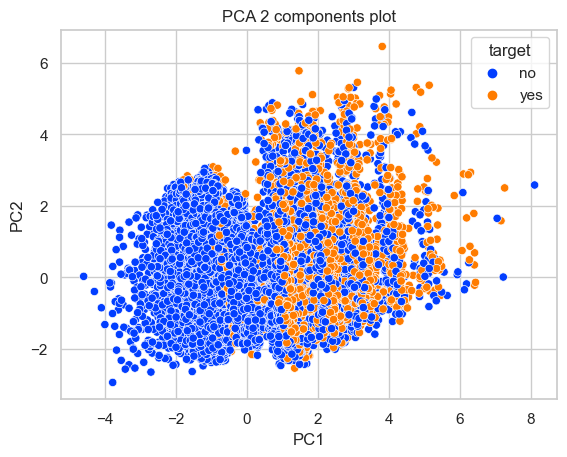

In [107]:
sns.scatterplot(data=plot_pca2, x="PC1", y="PC2", hue="target")
plt.title("PCA 2 components plot")
plt.show()

By reducing the dimensionality to two components, we observe a projection of points that exhibit certain grouping patterns. Notably, there is a concentration of points with a "yes" value for the target on the right side, while on the left side, there is a higher density of points with a "no" value.

Use of PCA to retain at least 95% of the variance in the data:

In [108]:
pca = PCA(n_components=0.95).fit(X)
pca.explained_variance_ratio_.shape[0]

22

^___ We can reduce the number of features to the quantity indicated in the above output.

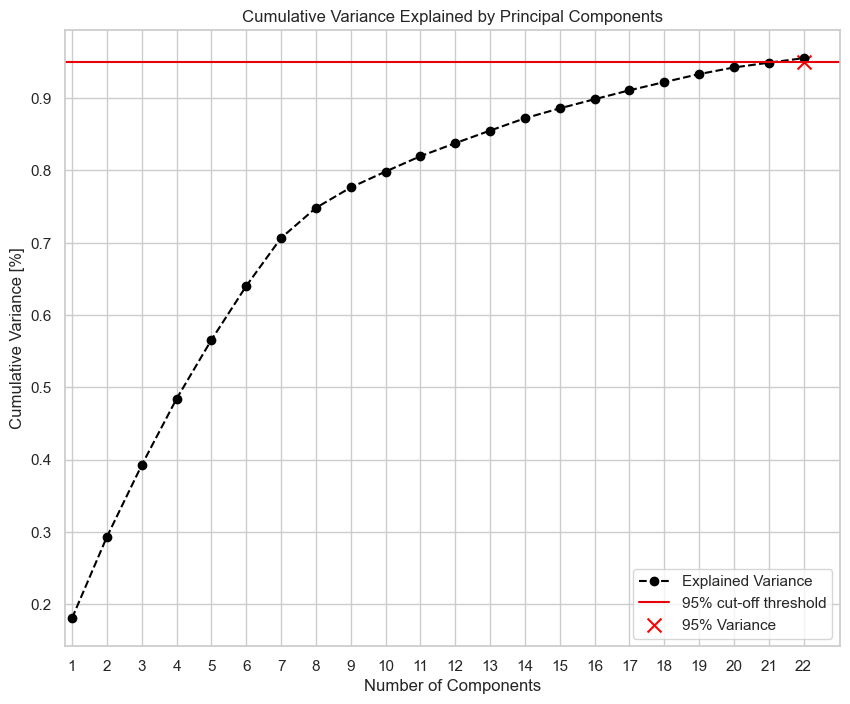

In [109]:
number_of_ticks = len(pca.explained_variance_ratio_) + 1
fig, ax = plt.subplots(figsize=(10, 8))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.plot(x_ticks, y_values, marker="o", linestyle="--", color="black", label="Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="-", label="95% cut-off threshold")
plt.scatter(x=np.argmax(y_values >= 0.95) + 1, y=0.95, color="red", marker="x", s=100, label="95% Variance")

plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance [%]")
plt.title("Cumulative Variance Explained by Principal Components")

plt.xlim(left=0.8)
plt.legend()
ax.grid(True)
plt.show()

## t-Stochastic Neighbor Embedding (t-SNE)

In [110]:
X_pca = PCA(n_components=0.95).fit_transform(X)
tsne = TSNE(perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

- visualization

In [111]:
plot_tsne = pd.DataFrame.from_records(data=X_tsne, columns=["X_TSNE", "Y_TSNE"])
plot_tsne["target"] = df["y"].replace({0: "no", 1: "yes"})

In [112]:
plot_tsne

X_TSNE     Y_TSNE target
0     -11.834013  85.984459     no
1     -29.709549  85.458237     no
2     -25.719757  62.483150     no
3     -11.919231  81.559677     no
4     -35.870953  68.345345     no
...          ...        ...    ...
38229  42.223331  40.632496    yes
38230  41.541592  37.862564     no
38231  42.146748  39.833290     no
38232  41.472759  37.723892    yes
38233  50.189861  52.749664     no

[38234 rows x 3 columns]

- example plot for a perplexity hyperparameter set to 30

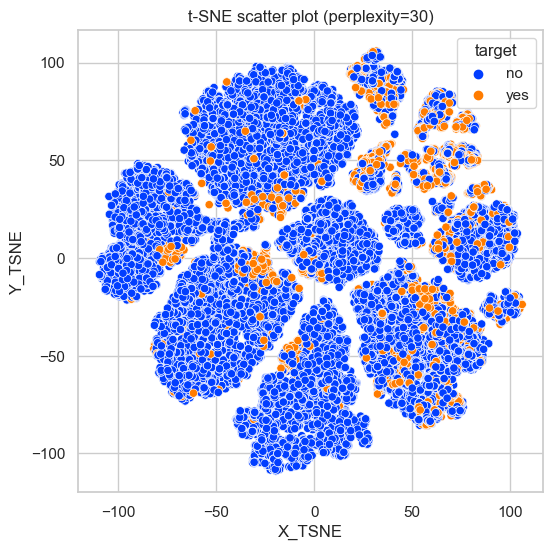

In [113]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=plot_tsne, x="X_TSNE", y="Y_TSNE", hue="target")
plt.title("t-SNE scatter plot (perplexity=30)")
plt.show()

- example plots for chosen perplexity hyperparameter values

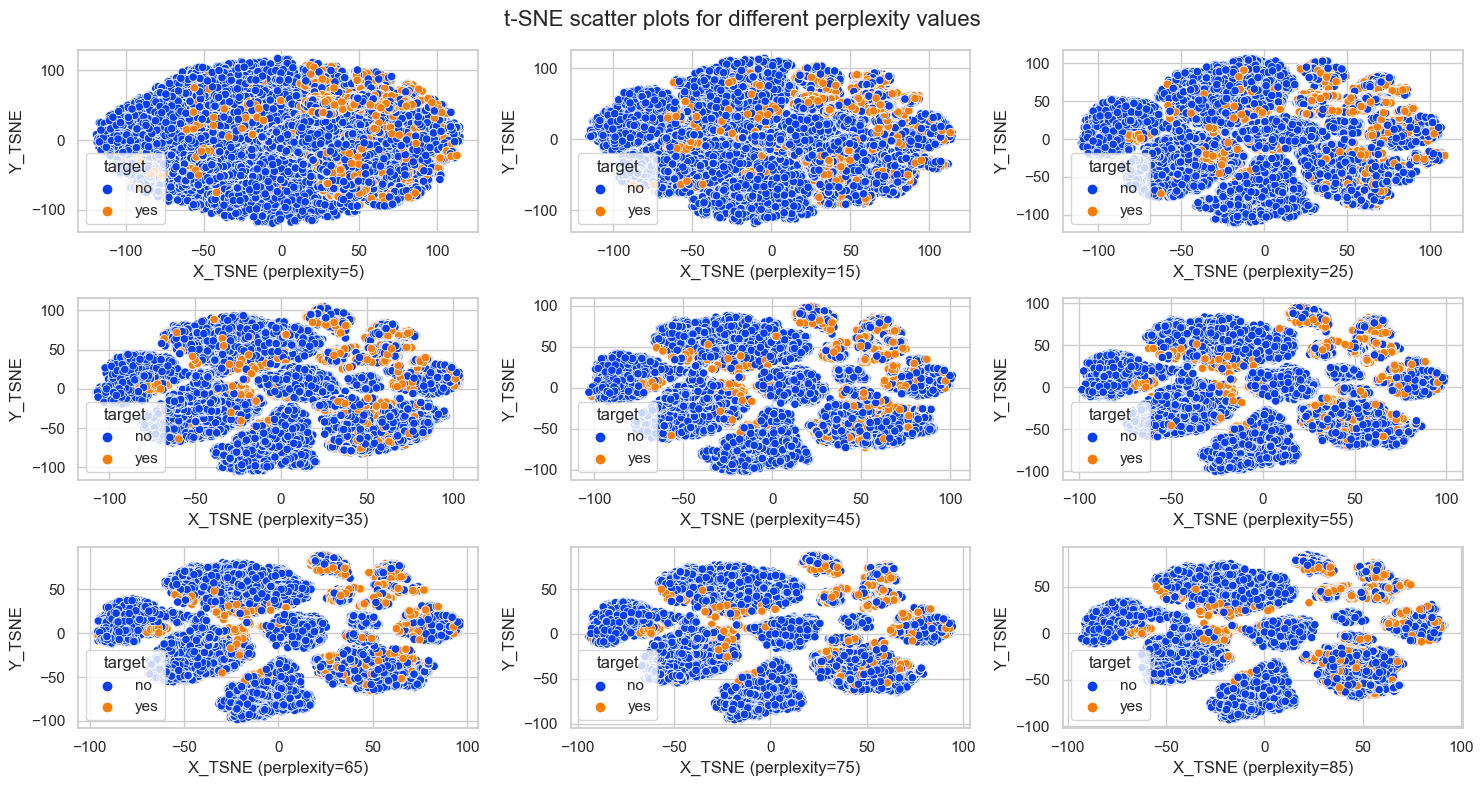

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, perplexity in enumerate([5, 15, 25, 35, 45, 55, 65, 75, 85]):
    X_pca = PCA(n_components=0.95).fit_transform(X)
    tsne = TSNE(perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_pca)
    plot_tsne = pd.DataFrame.from_records(data=X_tsne, columns=["X_TSNE", "Y_TSNE"])
    plot_tsne["target"] = df["y"].replace({0: "no", 1: "yes"})
    
    g = sns.scatterplot(data=plot_tsne, x="X_TSNE", y="Y_TSNE", hue="target", ax=axes[i])
    g.set(xlabel=f"X_TSNE (perplexity={perplexity})")

plt.suptitle("t-SNE scatter plots for different perplexity values", fontsize=16)
plt.tight_layout()
plt.show()

In the context of dimensionality reduction, a combination of PCA and t-SNE was employed. This hybrid approach was chosen because it was necessary to reduce the dimensionality to a level below 30 dimensions, approximately 22. The use of PCA is initially recommended to achieve this reduction, followed by the application of t-SNE. The combination of these two techniques is suggested by the authors of t-SNE for optimal results in capturing complex relationships within the data.

As the perplexity hyperparameter is increased, we observe the formation of distinct clusters. The optimal range for the perplexity value in this scenario appears to be between 30 and 60. Within this range, we can notice a highlighted global structure and achieve enhanced visual results.